In [2]:
import pickle 
import numpy as np
import matplotlib.pyplot as plt
import scipy
from scipy.stats.mstats import mquantiles
from scipy import stats
import matplotlib.colors as mcolors

# Data Indexing and Reshaping 

(566, 8760, 14) (311, 8760, 14)


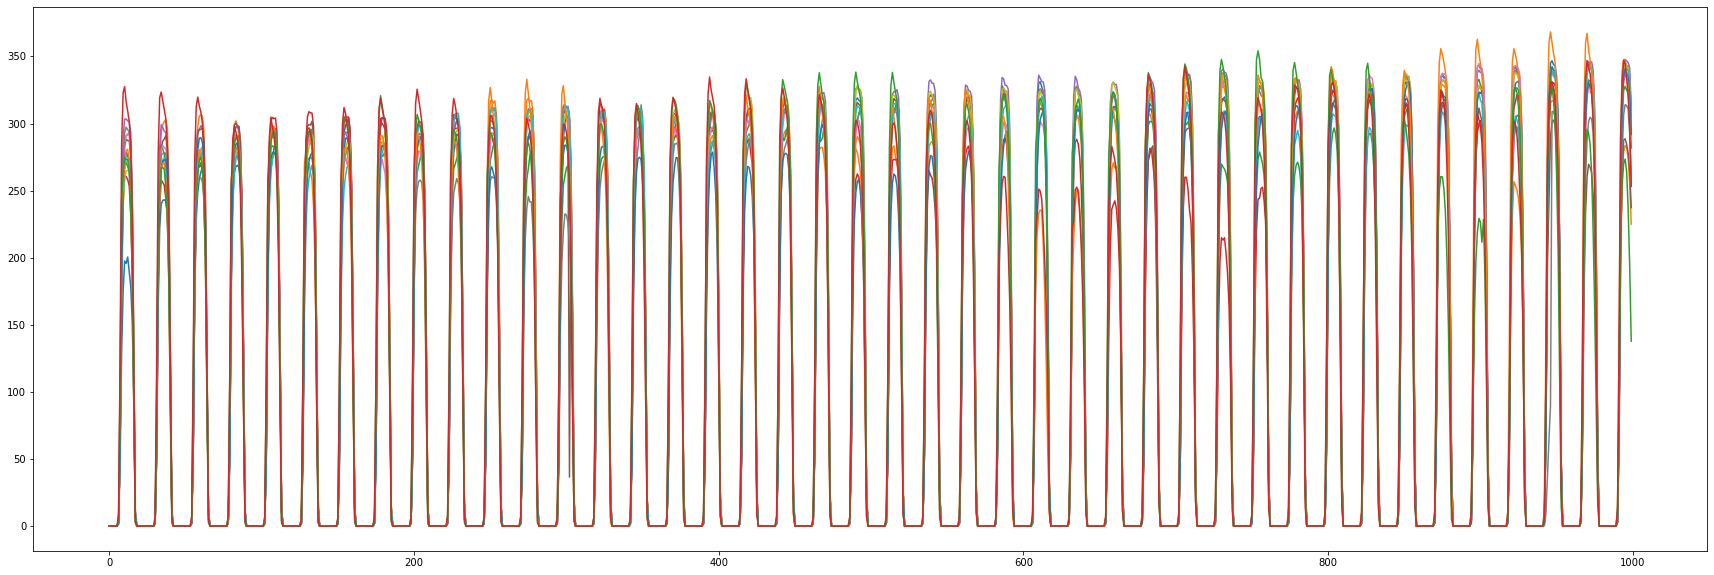

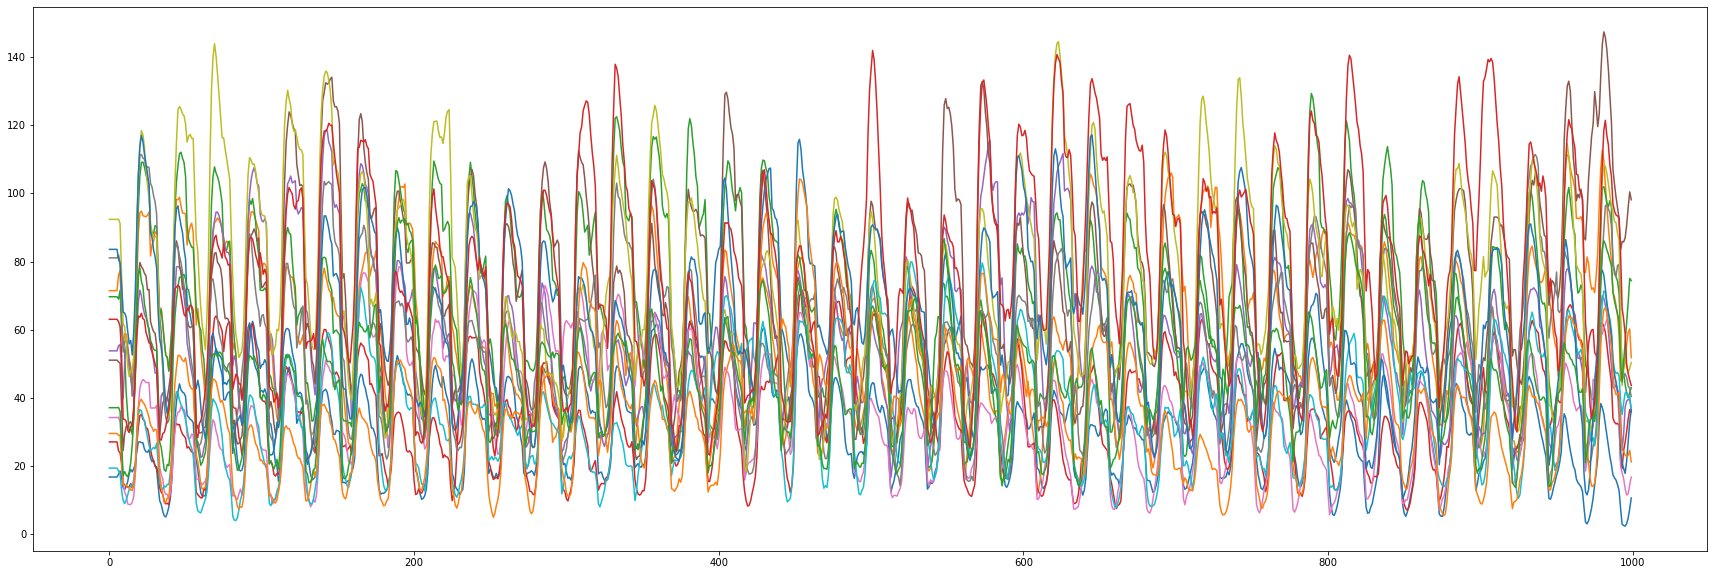

AttributeError: 'list' object has no attribute 'shape'

In [3]:
with open('india_power_dataset.pkl', 'rb') as _file:
    load_, mapre_, capacity_ = pickle.load(_file)
    L_, time_                          = load_  
    s_Cap_,  w_Cap_               = mapre_
    S_cf_, W_cf_                       = capacity_

S_cf_ = np.delete(S_cf_, [0, 4, 8, 12], axis = 2)
W_cf_ = np.delete(W_cf_, [0, 4, 8, 12], axis = 2)
print(S_cf_.shape, W_cf_.shape)

S_Cap_ = np.array(s_Cap_)[:, np.newaxis]
W_Cap_ = np.array(w_Cap_)[:, np.newaxis]

plt.figure(figsize = (30, 10))
plt.plot(np.sum(S_cf_, axis = 0)[:1000])
plt.show()

plt.figure(figsize = (30, 10))
plt.plot(np.sum(W_cf_, axis = 0)[:1000])
plt.show()
print(s_Cap_.shape, w_Cap_.shape)

# Total Load and reshape 

In [5]:
# Load Reshape
l_ = np.sum(L_ , axis = 1)[:, np.newaxis] # hourly energy demand in India
L = np.sum(l_, axis = 0) # total energy demand of India
L_reshape_ = L_.reshape(365, 24, 23) #
L_prime_ = np.sum(L_reshape_,axis = 2) 
L_days_ = np.sum( L_prime_, axis= 1)[:,np.newaxis]# L_(days,1)
print(l_)

[[212543]
 [206743]
 [202817]
 ...
 [236711]
 [229283]
 [221256]]


# Average system scale 

In [8]:
def _avg_system_scale(S_cf_,W_cf_, s_Cap_, w_Cap_, L, r_s, OB):
    r_w = 1 - r_s
    #1
    s_Cap_prime_ = np.repeat(s_Cap_[..., np.newaxis], 8760, axis = 1)
    s_Cap_prime_ = np.repeat(s_Cap_prime_[..., np.newaxis], S_cf_.shape[2], axis = 2)
    w_Cap_prime_ = np.repeat(np.array(w_Cap_)[..., np.newaxis], 8760, axis = 1)
    w_Cap_prime_ = np.repeat(w_Cap_prime_[..., np.newaxis], W_cf_.shape[2], axis = 2)
    print(s_Cap_prime_.shape)
    E_s_pot_year_ = s_Cap_prime_ * S_cf_
    E_w_pot_year_ = w_Cap_prime_ * np.array(W_cf_)
    #2
    e_s_tot_years_ = np.sum(np.sum(E_s_pot_year_, axis = 0), axis = 0)[:, np.newaxis]
    e_w_tot_years_ = np.sum(np.sum(E_w_pot_year_, axis = 0), axis = 0)[:, np.newaxis]
    #3 
    beta_s_ = L/e_s_tot_years_
    beta_hat_s = np.mean(beta_s_) 
    
    beta_w_ = L/e_w_tot_years_
    beta_hat_w = np.mean(beta_w_) 
    
    #4 solar 
    a_s_avg = r_s * beta_hat_s * OB
    a_w_avg = r_w * beta_hat_w * OB

    return a_s_avg , a_w_avg, beta_s_, beta_w_


r_s = .25
OB  = 1.75

a_hat_s, a_hat_w, beta_s_, beta_w_ = _avg_system_scale(S_cf_, W_cf_, s_Cap_, w_Cap_, L, r_s, OB)

TypeError: list indices must be integers or slices, not tuple

# Reliability Scenrios  Functions

In [23]:
def _battery_model(L_net, SOC, b_Cap): 
    
    def __discarge(L_net, SOC):
        D = abs(L_net)
        if D <= SOC: 
            SOC -= D
        else:
            D   = SOC 
            SOC = 0.
        return D, SOC 
    
    def __charge(L_net, SOC, b_Cap):
        C = L_net
        if (SOC + C) <= b_Cap:
            SOC += C 
        else:
            C   = b_Cap - SOC 
            SOC = b_Cap         
        return C, SOC
    #print(L_net, SOC, b_Cap)
    # Shedding 
    if L_net < 0.:
        D, SOC_star = __discarge(L_net, SOC) 
        return L_net + D, SOC_star
        
    # Balanced 
    if L_net == 0.: 
        return L_net, SOC 
    
    # Curtailment
    if L_net > 0.:
        C, SOC_star = __charge(L_net, SOC, b_Cap)
        return L_net - C, SOC_star
    
def _eval_reliability(L_net_, L_):
    l_net_ = L_net_.flatten()
    # Hourly Reliability
    balanced  = np.sum(l_net_ == 0., axis = 0)
    curtailed = np.sum(l_net_ > 0. , axis = 0)
    shedded   = np.sum(l_net_ < 0. , axis = 0)

    R_time = (balanced + curtailed)/(shedded + curtailed + balanced)
    #Energy Balance Reliability
    idx_         = L_net_ >= 0.
    L_net_[idx_] = 0.
    R_energy     = np.mean((L_.flatten() + L_net_.flatten())/L_.flatten())

    return R_time, R_energy


def _simulate_scenario(S_cf_, W_cf_, s_Cap_, w_Cap_, L_, L, r_b, r_s, OB):
    
    # Compute System Scale
    a_hat_s, a_hat_w, beta_s_, beta_w_ = _avg_system_scale(S_cf_, W_cf_, s_Cap_, w_Cap_, L, r_s, OB)

    # Scale Solar System
    E_s_scaled_ = a_hat_s * S_Cap_[:, :, np.newaxis] * S_cf_
    E_s_hour_   = np.sum(E_s_scaled_, axis= 0)

    # Scale Wind System
    E_w_scaled_ = a_hat_w * W_Cap_[:, :, np.newaxis] * W_cf_
    E_w_hour_   = np.sum(E_w_scaled_, axis= 0)
    
    b_Cap = r_b * L / 8760.

    L_net_ = np.zeros(E_w_hour_.shape)
    L_bat_ = np.zeros(E_w_hour_.shape)
    SOC_   = np.zeros(E_w_hour_.shape)

    SOC = 0.

    for i in range(8760):
        for j in range(14):
            # Compute hourly net demand
            L_net_[i, j] = (E_s_hour_[i, j] + E_w_hour_[i, j]) - L_[i, j] 
            # Upate Baterry State Of Charge and Net Load
            if r_b > 0:
                L_net_[i, j], SOC_[i, j] = _battery_model(L_net_[i, j], SOC, b_Cap)
            else:
                pass
            SOC = SOC_[i, j]
    return L_net_

 

# Reliability Scenrios 

In [18]:
r_s_ = [0.,.25, .5, .75, 1.]
r_b_ = [0, 1, 2, 4, 8, 12]
OB_  = [1., 1.75]

L_  = np.repeat(l_, 14, axis = 1)
print(L_.shape)

R_time_   = np.zeros((len(r_s_),len(r_b_),len(OB_)))
R_energy_ =np.zeros((len(r_s_),len(r_b_),len(OB_)))
variables_ = [] 
for i in range((len(r_s_))) :
    for j in range(len(r_b_)) :
        for k in range(len(OB_)) :

            L_net_ = _simulate_scenario(S_cf_, W_cf_, s_Cap_, w_Cap_, L_, L, r_b_[j], r_s_[i], OB_[k])
            R_time , R_energy  = _eval_reliability(L_net_, L_)
            
            R_time_[i,j,k]   = R_time
            R_energy_[i,j,k] = R_energy
            variables_.append([ r_s_[i], r_b_[j], OB_[k]])

(8760, 14)


NameError: name '_simulate_scenario' is not defined

/var/folders/99/fl4_sjvj2px9bv5z1fjz0w600000gn/T/ipykernel_21842/3406356747.py:14: UserWarning: FixedFormatter should only be used together with FixedLocator
  cbar.set_ticklabels( cbar.get_ticks(), fontsize=22)


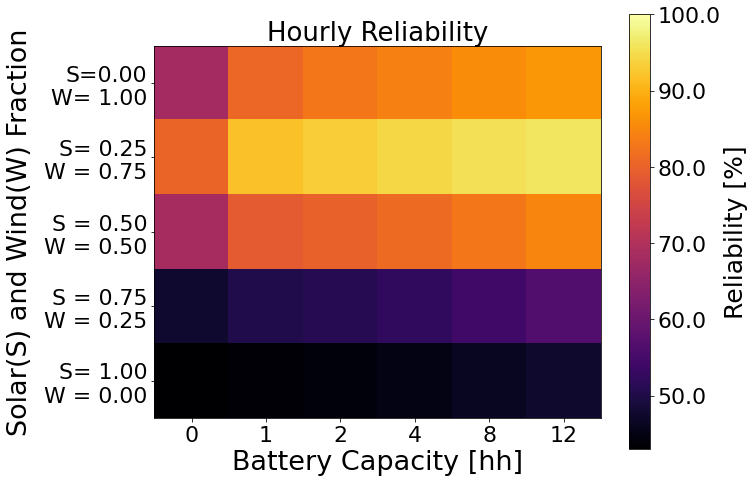

0.962059686888454


In [25]:
plt.figure(figsize=(10,8))
plt.title( 'Hourly Reliability', fontsize = 26 )

plt.imshow(R_time_[:, :, 1] * 100., interpolation = 'none', vmax = 100, cmap = 'inferno')

plt.yticks([0,1,2,3,4],['S=' + "{:.2f}".format(r_s_[0]) + '\n' + 'W= '+  "{:.2f}".format(1-r_s_[0]),
                 'S= ' + "{:.2f}".format(r_s_[1]) + '\n' + 'W = '+  "{:.2f}".format(1-r_s_[1]),
                 'S = ' + "{:.2f}".format(r_s_[2]) + '\n' + 'W = '+  "{:.2f}".format(1-r_s_[2]),
                 'S = ' + "{:.2f}".format(r_s_[3]) + '\n' + 'W = '+  "{:.2f}".format(1-r_s_[3]),
                 'S= ' + "{:.2f}".format(r_s_[4]) + '\n' +' W = '+  "{:.2f}".format(1-r_s_[4])], fontsize = 22)
plt.xticks([0,1,2,3,4,5], r_b_, fontsize=22)

cbar = plt.colorbar()
cbar.set_ticklabels( cbar.get_ticks(), fontsize=22)
cbar.set_label(label = 'Reliability [%]', fontsize=25)

plt.ylabel('Solar(S) and Wind(W) Fraction', fontsize=27) 
plt.xlabel('Battery Capacity [hh]',fontsize=27)

plt.savefig('/Users/dlopez/Desktop/india_power/Images/' + '_Hourly_Reliability.png',dpi='figure',bbox_inches='tight')


plt.show()

print(R_time_[:, :, 1].max())

/var/folders/99/fl4_sjvj2px9bv5z1fjz0w600000gn/T/ipykernel_21842/363232791.py:14: UserWarning: FixedFormatter should only be used together with FixedLocator
  cbar.set_ticklabels(cbar.get_ticks(), fontsize=22)


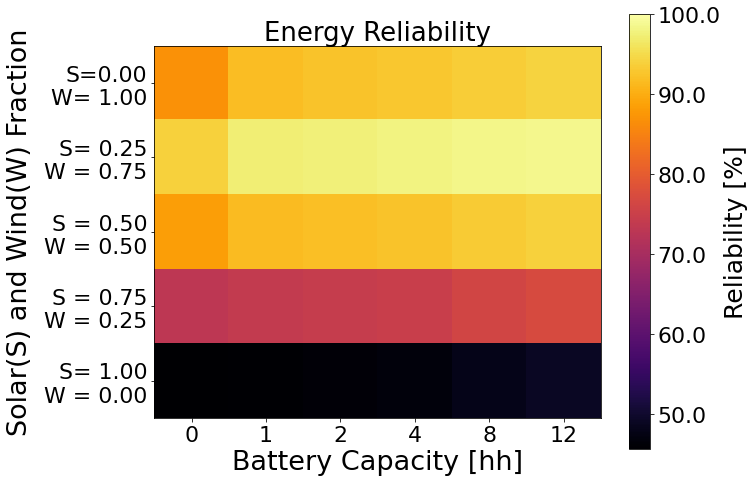

In [26]:
plt.figure(figsize=(10,8))
plt.title( 'Energy Reliability', fontsize = 26 )

plt.imshow(R_energy_[:,:,1] * 100,interpolation = 'none',vmax=100, cmap = 'inferno')

plt.yticks([0,1,2,3,4],['S=' + "{:.2f}".format(r_s_[0]) + '\n' + 'W= '+  "{:.2f}".format(1-r_s_[0]),
                 'S= ' + "{:.2f}".format(r_s_[1]) + '\n' + 'W = '+  "{:.2f}".format(1-r_s_[1]),
                 'S = ' + "{:.2f}".format(r_s_[2]) + '\n' + 'W = '+  "{:.2f}".format(1-r_s_[2]),
                 'S = ' + "{:.2f}".format(r_s_[3]) + '\n' + 'W = '+  "{:.2f}".format(1-r_s_[3]),
                 'S= ' + "{:.2f}".format(r_s_[4]) + '\n' +' W = '+  "{:.2f}".format(1-r_s_[4])], fontsize = 22)

plt.xticks([0,1,2,3,4,5], r_b_ , fontsize=22)
cbar = plt.colorbar()
cbar.set_ticklabels(cbar.get_ticks(), fontsize=22)
cbar.set_label(label = 'Reliability [%]', fontsize=25)

plt.ylabel('Solar(S) and Wind(W) Fraction', fontsize=27) 
plt.xlabel('Battery Capacity [hh]',fontsize=27)

plt.savefig('/Users/dlopez/Desktop/india_power/Images/' + 'Energy_Reliability.png',dpi='figure',bbox_inches='tight')


plt.show()
s_Cap_r_
w_Cap_r_

# Seasonal Varability Functions

In [27]:
def _daily_stats(Data_):  
    # Median
    med_      = np.mean(Data_, axis = 0)
    # Quantile Statistics
    quantiles = stats.mstats.mquantiles(Data_, [0.025, 0.2, 0.8, .975], axis = 0)
    q_0_      = quantiles[0, :]
    q_25_     = quantiles[1, :]
    q_75_     = quantiles[2, :]
    q_100_    = quantiles[3, :]
    return med_[:, np.newaxis], q_0_[:, np.newaxis], q_25_[:, np.newaxis], q_75_[:, np.newaxis], q_100_[:, np.newaxis]

# To find the average daily generation 
def hourly_solar(S_cf_, S_Cap_, season_idx_, a_hat_s, y):
    E_s_scaled_a_ =  a_hat_s * S_Cap_ * S_cf_[:, :, y] 
    E_s_hour_a_ = np.sum(E_s_scaled_a_, axis = 0) # (hours,years)
    E_s_prime_ = E_s_hour_a_.reshape(365, 24)
    #solar 
    S_w_   = E_s_prime_[season_idx_[0], :] 
    S_spr_ = E_s_prime_[season_idx_[1], :] 
    S_smr_ = E_s_prime_[season_idx_[2], :] 
    S_f_   = E_s_prime_[season_idx_[3], :] 
    return S_w_, S_spr_, S_smr_, S_f_

def hourly_wind(W_cf_, W_Cap_, season_idx_,  a_hat_s, y):
    E_w_scaled_a_ =  a_hat_s * W_Cap_ * W_cf_[:, :, y] 
    E_w_hour_a_   = np.sum(E_w_scaled_a_, axis= 0) # (hours,years)
    E_w_prime_    = E_w_hour_a_.reshape(365, 24)
    #solar 
    W_w_   = E_w_prime_[season_idx_[0], :] 
    W_spr_ = E_w_prime_[season_idx_[1], :] 
    W_smr_ = E_w_prime_[season_idx_[2], :] 
    W_f_   = E_w_prime_[season_idx_[3], :] 
    return W_w_, W_spr_, W_smr_, W_f_

# Seasonal Varability 

In [28]:
# season indexing 
#seasons
idx_days_ = np.arange(365, dtype = int)

spring_begin = 79
spring_end   = 169
idx_spring_  = ((idx_days_ >= spring_begin) & (idx_days_ < spring_end))
print(idx_spring_.sum())

summer_begin = 169
summer_end   = 261
idx_summer_  = ((idx_days_ >= summer_begin) & (idx_days_ < summer_end))
print(idx_summer_.sum())

fall_begin = 261
fall_end   = 352
idx_fall_  = ((idx_days_ >= fall_begin) & (idx_days_ < fall_end))
print(idx_fall_.sum())

winter_begin = 0
winter_end   = 79
winter_Begin = 352
winter_End   = 365
idx_winter_  = (((idx_days_ >= winter_begin) & (idx_days_ < winter_end)) | ((idx_days_ >= winter_Begin) & (idx_days_ <= winter_End)))
print(idx_winter_.sum())

season_idx_ = np.array([idx_winter_, idx_spring_, idx_summer_, idx_fall_])
print(season_idx_.shape)

90
92
91
92
(4, 365)


In [1]:
r_s = .5
r_w = 1.  - r_s
OB  = 1.

a_hat_s, a_hat_w, beta_s_, beta_w_ = _avg_system_scale(S_cf_, W_cf_, s_Cap_, w_Cap_, L, r_s, OB)


# average seasonal daily generation 
N_years    = S_cf_.shape[2]
S_gen_w_   = np.zeros((N_years, 92, 24))
S_gen_spr_ = np.zeros((N_years, 90, 24))
S_gen_smr_ = np.zeros((N_years, 92, 24))
S_gen_f_   = np.zeros((N_years, 91, 24))

for i in range(N_years):
    S_gen_w_[i], S_gen_spr_[i], S_gen_smr_[i], S_gen_f_[i] = hourly_solar(S_cf_, S_Cap_, season_idx_, a_hat_s, i)
print(S_gen_w_.shape)

S_gen_w_   = S_gen_w_.reshape(S_gen_w_.shape[0]*S_gen_w_.shape[1], S_gen_w_.shape[2])
S_gen_spr_ = S_gen_spr_.reshape(S_gen_spr_.shape[0]*S_gen_spr_.shape[1], S_gen_spr_.shape[2])
S_gen_smr_ = S_gen_smr_.reshape(S_gen_smr_.shape[0]*S_gen_smr_.shape[1], S_gen_smr_.shape[2])
S_gen_f_   = S_gen_f_.reshape(S_gen_f_.shape[0]*S_gen_f_.shape[1], S_gen_f_.shape[2])
print(S_gen_w_.shape)
N_years    = W_cf_.shape[2]
W_gen_w_   = np.zeros((N_years, 92, 24))
W_gen_spr_ = np.zeros((N_years , 90, 24))
W_gen_smr_ = np.zeros((N_years, 92, 24))
W_gen_f_   = np.zeros((N_years, 91, 24))

for i in range(N_years):
    W_gen_w_[i], W_gen_spr_[i], W_gen_smr_[i], W_gen_f_[i] = hourly_wind(W_cf_, W_Cap_, season_idx_,  a_hat_w, i)
print(W_gen_w_.shape)

W_gen_w_  = W_gen_w_.reshape(W_gen_w_.shape[0]*W_gen_w_.shape[1], W_gen_w_.shape[2])
W_gen_spr_ = W_gen_spr_.reshape(W_gen_spr_.shape[0]*W_gen_spr_.shape[1], W_gen_spr_.shape[2])
W_gen_smr_ = W_gen_smr_.reshape(W_gen_smr_.shape[0]*W_gen_smr_.shape[1], W_gen_smr_.shape[2])
W_gen_f_   = W_gen_f_.reshape(W_gen_f_.shape[0]*W_gen_f_.shape[1], W_gen_f_.shape[2])

#season stats
S_w_med_, S_w_q_0_ , S_w_q_25_, S_w_q_75_, S_w_q_100_           = _daily_stats(S_gen_w_) 
S_spr_med_, S_spr_q_0_ , S_spr_q_25_, S_spr_q_75_, S_spr_q_100_ = _daily_stats(S_gen_spr_)
S_smr_med_, S_smr_q_0_ , S_smr_q_25_, S_smr_q_75_, S_smr_q_100_ = _daily_stats(S_gen_smr_)
S_f_med_, S_f_q_0_ , S_f_q_25_, S_f_q_75_, S_f_q_100_           = _daily_stats(S_gen_f_)  

W_w_med_, W_w_q_0_ , W_w_q_25_, W_w_q_75_, W_w_q_100_           = _daily_stats(W_gen_w_) 
W_spr_med_, W_spr_q_0_ , W_spr_q_25_, W_spr_q_75_, W_spr_q_100_ = _daily_stats(W_gen_spr_)
W_smr_med_, W_smr_q_0_ , W_smr_q_25_, W_smr_q_75_, W_smr_q_100_ = _daily_stats(W_gen_smr_)
W_f_med_, W_f_q_0_ , W_f_q_25_, W_f_q_75_, W_f_q_100_           = _daily_stats(W_gen_f_)

# seasonal Load 
L_w_   = L_prime_[idx_winter_, :]
L_spr_ = L_prime_[idx_spring_, :] 
L_smr_ = L_prime_[idx_summer_, :]
L_f_   = L_prime_[idx_fall_, :]
# Load stats 
l_w_med_, l_w_q_0_, l_w_q_25_, l_w_q_75_, l_w_q_100_            = _daily_stats(L_w_)
l_spr_med_, l_spr_q_0_ , l_spr_q_25_, l_spr_q_75_, l_spr_q_100_ = _daily_stats(L_spr_)
l_smr_med_, l_smr_q_0_ , l_smr_q_25_, l_smr_q_75_, l_smr_q_100_ = _daily_stats(L_smr_)
l_f_med_, l_f_q_0_ , l_f_q_25_, l_f_q_75_, l_f_q_100_           = _daily_stats(L_f_)

NameError: name '_avg_system_scale' is not defined

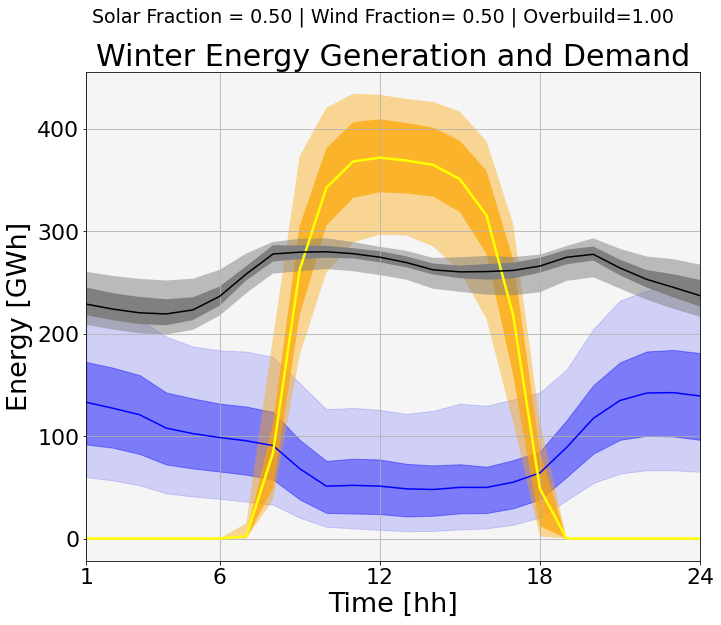

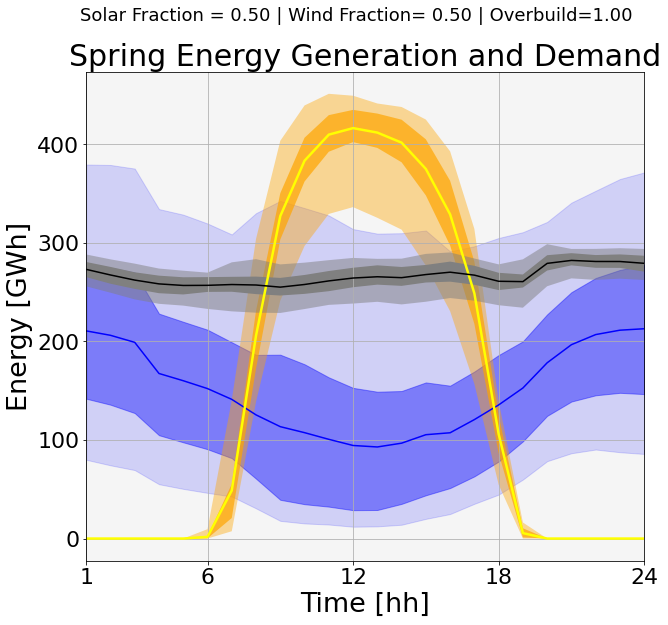

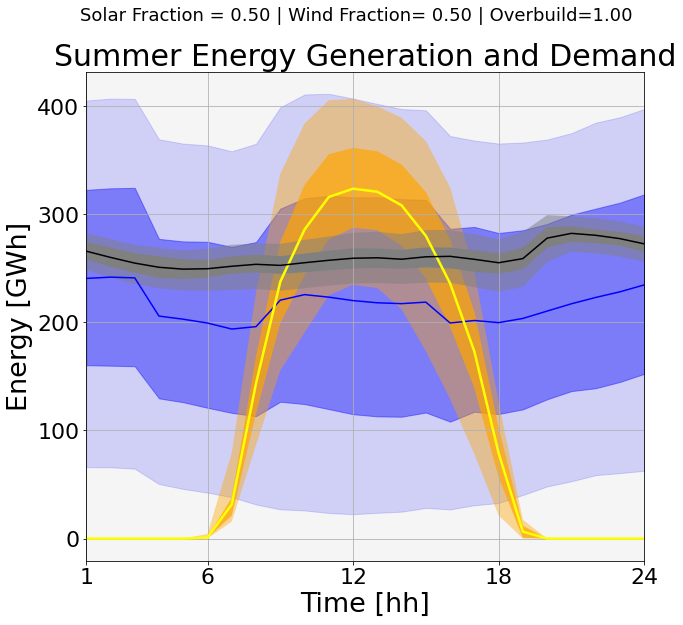

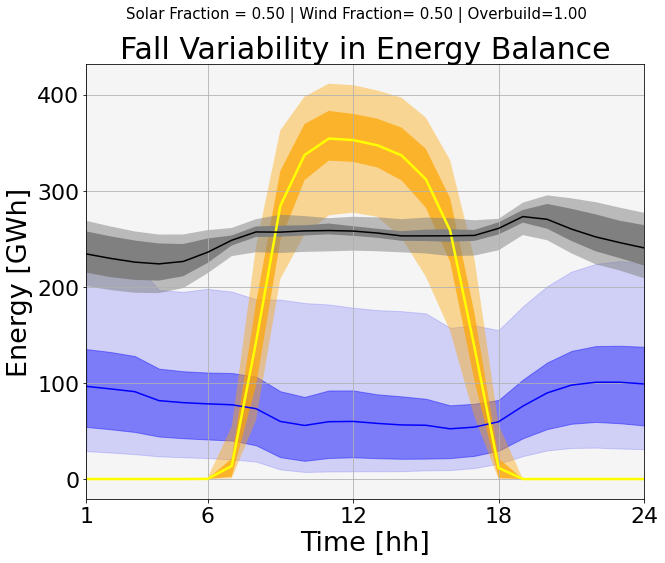

In [30]:
# winter
x_ = np.arange(0,24,1, dtype = int)
plt.figure(figsize = (11, 9))
plt.gca().set_facecolor('whitesmoke')

plt.plot(x_,W_w_med_/1000, 'b', label = 'Average Wind Generation',)
plt.fill_between(x_, W_w_q_0_[:, 0]/1000., W_w_q_100_[:, 0]/1000.,alpha = 0.15,  edgecolor = 'blue', facecolor = 'blue', label = '$Q_{2.5}-Q_{97.5}$')
plt.fill_between(x_, W_w_q_25_[:, 0]/1000., W_w_q_75_[:, 0]/1000., alpha = 0.4,  edgecolor = 'blue', facecolor = 'blue', label = '$Q_{20}-Q_{80}$')

plt.plot(x_, S_w_med_/1000, color = 'yellow', linewidth = 2.5, label = 'Average Solar Generation')
plt.fill_between(x_, S_w_q_0_[:, 0]/1000., S_w_q_100_[:, 0]/1000., alpha = 0.4,  edgecolor = 'none', facecolor = 'orange', label = '$Q_{2.5}-Q_{97.5}$')
plt.fill_between(x_, S_w_q_25_[:, 0]/1000., S_w_q_75_[:, 0]/1000., alpha = .7,  edgecolor = 'none', facecolor = 'orange', label = '$Q_{20}-Q_{80}$')

plt.plot(x_, l_w_med_/1000, 'k', label = 'Average Load Demand')
plt.fill_between(x_, l_w_q_0_[:, 0]/1000., l_w_q_100_[:, 0]/1000., alpha = 0.5,  edgecolor = 'none', facecolor = 'gray', label = '$Q_{2.5}-Q_{97.5}$')
plt.fill_between(x_, l_w_q_25_[:, 0]/1000., l_w_q_75_[:, 0]/1000., alpha = 1.,  edgecolor = 'none', facecolor = 'gray', label = '$Q_{20}-Q_{80}$')

plt.title('Winter Energy Generation and Demand', fontsize= 30, loc = 'center')
plt.suptitle('Solar Fraction = ' +  "{:.2f}".format(r_s) + ' | Wind Fraction= '+  "{:.2f}".format(1-r_s) + ' | Overbuild=' +  "{:.2f}".format(OB) , ha = 'center', va = 'top',fontsize=19.)


plt.xlabel('Time [hh]', fontsize = 27)
plt.ylabel('Energy [GWh]', fontsize = 27 )

plt.xlim([0, 23])
plt.xticks([0, 5, 11, 17, 23], [1, 6, 12, 18, 24], fontsize = 22)
plt.yticks(fontsize = 22.)

#plt.legend(bbox_to_anchor=(1.05, 1.0), loc ='upper left' ,fontsize = 20.)
plt.savefig('/Users/dlopez/Desktop/india_power/Images/' + 'Winter'+ "_{:.2f}".format(r_s) + '_'+ "{:.2f}".format(1-r_s)+'_'+ "{:.1f}.png".format(OB), dpi='figure',bbox_inches='tight')

plt.grid()
plt.show()

# spring
plt.figure(figsize = (10, 9))
plt.gca().set_facecolor('whitesmoke')

plt.plot(x_,W_spr_med_/1000, 'b', label = 'Average Wind Generation')
plt.fill_between(x_, W_spr_q_0_[:, 0]/1000., W_spr_q_100_[:, 0]/1000.,alpha = 0.15,  edgecolor = 'blue', facecolor = 'blue', label = '$Q_{2.5}-Q_{100}$')
plt.fill_between(x_, W_spr_q_25_[:, 0]/1000., W_spr_q_75_[:, 0]/1000., alpha = 0.4,  edgecolor = 'blue', facecolor = 'blue', label = '$Q_{20}-Q_{80}$')

plt.plot(x_, S_spr_med_/1000, color = 'yellow', linewidth = 2.5, label = 'Average Solar Generation')
plt.fill_between(x_, S_spr_q_0_[:, 0]/1000., S_spr_q_100_[:, 0]/1000., alpha = 0.4,  edgecolor = 'none', facecolor = 'orange', label = '$Q_{2.5}-Q_{97.5}$')
plt.fill_between(x_, S_spr_q_25_[:, 0]/1000., S_spr_q_75_[:, 0]/1000., alpha = .7,  edgecolor = 'none', facecolor = 'orange', label = '$Q_{20}-Q_{80}$')

plt.plot(x_, l_spr_med_/1000, 'k', label = 'Average Load Demand')
plt.fill_between(x_, l_spr_q_0_[:, 0]/1000., l_spr_q_100_[:, 0]/1000., alpha = 0.5,  edgecolor = 'none', facecolor = 'gray', label = '$Q_{2.5}-Q_{97.5}$')
plt.fill_between(x_, l_spr_q_25_[:, 0]/1000., l_spr_q_75_[:, 0]/1000., alpha = 1.,  edgecolor = 'none', facecolor = 'gray', label = '$Q_{0}-Q_{100}$')

plt.title('Spring Energy Generation and Demand', fontsize=30, loc = 'center')
plt.suptitle('Solar Fraction = ' +  "{:.2f}".format(r_s) + ' | Wind Fraction= '+  "{:.2f}".format(r_w) + ' | Overbuild=' +  "{:.2f}".format(OB), ha = 'center', va = 'top',fontsize=18.)

plt.xlabel('Time [hh]', fontsize = 27)
plt.ylabel('Energy [GWh]', fontsize = 27 )
plt.xlim([0, 23])
plt.xticks([0, 5, 11, 17, 23], [1, 6, 12, 18, 24], fontsize= 22.)
plt.yticks(fontsize= 22.)

#plt.legend(bbox_to_anchor=(1.05, 1.0), loc='upper left' ,fontsize= 22.)
plt.savefig('/Users/dlopez/Desktop/india_power/Images/'+ '_Spring'+ "_{:.2f}".format(r_s) + '_'+ "{:.2f}".format(r_w)+'_'+  "{:.1f}.png".format(OB),dpi = 'figure',bbox_inches='tight')
plt.grid()
plt.show()

#summer
plt.figure(figsize = (10, 9))
plt.gca().set_facecolor('whitesmoke')

plt.plot(x_,W_smr_med_/1000, 'b', label = 'Average Wind Generation')
plt.fill_between(x_, W_smr_q_0_[:, 0]/1000., W_smr_q_100_[:, 0]/1000.,alpha = 0.15,  edgecolor = 'blue', facecolor = 'blue', label = '$Q_{2.5}-Q_{100}$')
plt.fill_between(x_, W_smr_q_25_[:, 0]/1000., W_smr_q_75_[:, 0]/1000., alpha = 0.4,  edgecolor = 'blue', facecolor = 'blue', label = '$Q_{0}-Q_{100}$')

plt.plot(x_, S_smr_med_/1000, color = 'yellow', linewidth = 2.5, label = 'Average Solar Generation')
plt.fill_between(x_, S_smr_q_0_[:, 0]/1000., S_smr_q_100_[:, 0]/1000., alpha = 0.4,  edgecolor = 'none', facecolor = 'orange', label = '$Q_{2.5}-Q_{97.5}$')
plt.fill_between(x_, S_smr_q_25_[:, 0]/1000., S_smr_q_75_[:, 0]/1000., alpha = .7,  edgecolor = 'none', facecolor = 'orange', label = '$Q_{20}-Q_{80}$')

plt.plot(x_, l_smr_med_/1000, 'k', label = 'Average Load Demand')
plt.fill_between(x_, l_smr_q_0_[:, 0]/1000., l_smr_q_100_[:, 0]/1000., alpha = 0.5,  edgecolor = 'none', facecolor = 'gray', label = '$Q_{0}-Q_{100}$')
plt.fill_between(x_, l_smr_q_25_[:, 0]/1000., l_smr_q_75_[:, 0]/1000., alpha = 1.,  edgecolor = 'none', facecolor = 'gray', label = '$Q_{0}-Q_{100}$')

plt.title('Summer Energy Generation and Demand', fontsize=30,loc = 'center')
plt.suptitle('Solar Fraction = ' +  "{:.2f}".format(r_s) + ' | Wind Fraction= '+  "{:.2f}".format(1-r_s) + ' | Overbuild=' +  "{:.2f}".format(OB), ha = 'center', va = 'top',fontsize=18.)


plt.xlabel('Time [hh]', fontsize = 27)
plt.ylabel('Energy [GWh]', fontsize = 27 )
plt.xlim([0, 23])
plt.xticks([0, 5, 11, 17, 23], [1, 6, 12, 18, 24], fontsize= 22.)
plt.yticks(fontsize= 22.)

#plt.legend(bbox_to_anchor=(1.05, 1.0), loc='upper left' ,fontsize= 22.)
plt.savefig('/Users/dlopez/Desktop/india_power/Images/'+ '_Summer'+ "_{:.2f}".format(r_s) + '_'+ "{:.2f}".format(1-r_s)+'_'+  "{:.1f}.png".format(OB), dpi='figure',bbox_inches='tight')


plt.grid()
plt.show()

# fall
plt.figure(figsize = (10, 8))
plt.gca().set_facecolor('whitesmoke')

plt.plot(x_,W_f_med_/1000, 'b', label = 'Average Wind Generation')
plt.fill_between(x_, W_f_q_0_[:, 0]/1000., W_f_q_100_[:, 0]/1000.,alpha = 0.15,  edgecolor = 'blue', facecolor = 'blue', label = '$Q_{2.5}-Q_{100}$')
plt.fill_between(x_, W_f_q_25_[:, 0]/1000., W_f_q_75_[:, 0]/1000., alpha = 0.4,  edgecolor = 'blue', facecolor = 'blue', label = '$Q_{0}-Q_{100}$')

plt.plot(x_, S_f_med_/1000, color = 'yellow', linewidth = 2.5, label = 'Average Solar Generation')
plt.fill_between(x_, S_f_q_0_[:, 0]/1000., S_f_q_100_[:, 0]/1000., alpha = 0.4,  edgecolor = 'none', facecolor = 'orange', label = '$Q_{2.5}-Q_{97.5}$')
plt.fill_between(x_, S_f_q_25_[:, 0]/1000., S_f_q_75_[:, 0]/1000., alpha = .7,  edgecolor = 'none', facecolor = 'orange', label = '$Q_{20}-Q_{80}$')

plt.plot(x_, l_f_med_/1000, 'k', label = 'Average Load Demand')
plt.fill_between(x_, l_f_q_0_[:, 0]/1000., l_f_q_100_[:, 0]/1000., alpha = 0.5,  edgecolor = 'none', facecolor = 'gray', label = '$Q_{0}-Q_{100}$')
plt.fill_between(x_, l_f_q_25_[:, 0]/1000., l_f_q_75_[:, 0]/1000., alpha = 1.,  edgecolor = 'none', facecolor = 'gray', label = '$Q_{0}-Q_{100}$')

plt.title('Fall Variability in Energy Balance', fontsize=30,loc = 'center')
plt.suptitle('Solar Fraction = ' +  "{:.2f}".format(r_s) + ' | Wind Fraction= '+  "{:.2f}".format(r_w) + ' | Overbuild=' +  "{:.2f}".format(OB), ha = 'center', va = 'top',fontsize=15.)


plt.xlabel('Time [hh]', fontsize = 27)
plt.ylabel('Energy [GWh]', fontsize = 27 )
plt.xlim([0, 23])
plt.xticks([0, 5, 11, 17, 23], [1, 6, 12, 18, 24], fontsize= 22.)
plt.yticks(fontsize= 22.)

plt.savefig('/Users/dlopez/Desktop/india_power/Images/'+ '_Fall'+ "_{:.2f}".format(r_s) + '_'+ "{:.2f}".format(r_w)+'_'+  "{:.2f}.png".format(OB), dpi='figure')

plt.grid()
plt.show()


# Ramp Rates

In [31]:
def _hourly_stats(data_):  
    #Quantile Statistics
    m  = np.mean(data_)
    q_ = stats.mstats.mquantiles(data_, [0.025, .2 ,0.8, .975])
    return m, q_

dt = 1
r_s = .25
r_w = 1 - r_s
OB  = 1.75
print(r_s, r_w, OB)

a_hat_s, a_hat_w, beta_s_, beta_w_ = _avg_system_scale(S_cf_, W_cf_, s_Cap_, w_Cap_, L, r_s, OB)
# Energy met reshaping 

E_s_scaled_ = a_hat_s * S_Cap_[:, :, np.newaxis] * S_cf_
E_s_hour_   = np.sum(E_s_scaled_, axis= 0)

E_w_scaled_ = a_hat_w * W_Cap_[:, :, np.newaxis]  * W_cf_
E_w_hour_   = np.sum(E_w_scaled_, axis= 0)
L_net_ = ( E_s_hour_ + E_w_hour_) - l_

Rr_dt1_ = np.diff(L_net_, n = dt, axis = 0)/dt
Rr_dt1_frac_ = (Rr_dt1_ / l_[dt:])*100.

rr_dt1_ = Rr_dt1_frac_[:24 - dt, :]
Rr_dt1_ = Rr_dt1_frac_[24 - dt:, :]

rr_dt1_prime_ = rr_dt1_.flatten()[np.newaxis, :]
Rr_dt1_prime_ = np.reshape(Rr_dt1_, (364, 24*14))

# Define Storage Vectors size of year days
idx_ = Rr_dt1_prime_ == 0.
print(idx_.sum())

m_pos_ = np.zeros((365, 1))
m_neg_ = np.zeros((365, 1))
Q_pos_ = np.zeros((365, 4))
Q_neg_ = np.zeros((365, 4))

# Compute stats for Janurary 1st positive
idx_ = rr_dt1_prime_[0, :] > 0.

jan_1_med_pos, jan_1_q_pos_ = _hourly_stats(rr_dt1_prime_[0, idx_])
jan_1_med_neg, jan_1_q_neg_ = _hourly_stats(rr_dt1_prime_[0, ~idx_])

# Save Januaray 1st stats in Storage Vectors
m_pos_[0]    = jan_1_med_pos
Q_pos_[0, :] = jan_1_q_pos_
m_neg_[0]    = jan_1_med_neg
Q_neg_[0, :] = jan_1_q_neg_

#Ramp Rates for each year
for i in range(Rr_dt1_prime_.shape[0]):
    idx_pos_ = Rr_dt1_prime_[i, :] > 0.
    
    med_pos, q_pos_ = _hourly_stats(Rr_dt1_prime_[i, idx_pos_])
    med_neg, q_neg_ = _hourly_stats(Rr_dt1_prime_[i, ~idx_pos_])

    m_pos_[i + 1] = med_pos
    m_neg_[i + 1] = med_neg
    Q_pos_[i + 1] = q_pos_
    Q_neg_[i + 1] = q_neg_

q_0_pos_      = Q_pos_[:,0]
q_25_pos_     = Q_pos_[:,1]
q_75_pos_     = Q_pos_[:,2]
q_100_pos_    = Q_pos_[:,3]    
q_0_neg_      = Q_neg_[:,0]
q_25_neg_     = Q_neg_[:,1]
q_75_neg_     = Q_neg_[:,2]
q_100_neg_    = Q_neg_[:,3]   
print(q_100_pos_.shape,m_neg_.shape,Q_pos_.shape,Q_neg_.shape)

0.25 0.75 1.75
0
(365,) (365, 1) (365, 4) (365, 4)


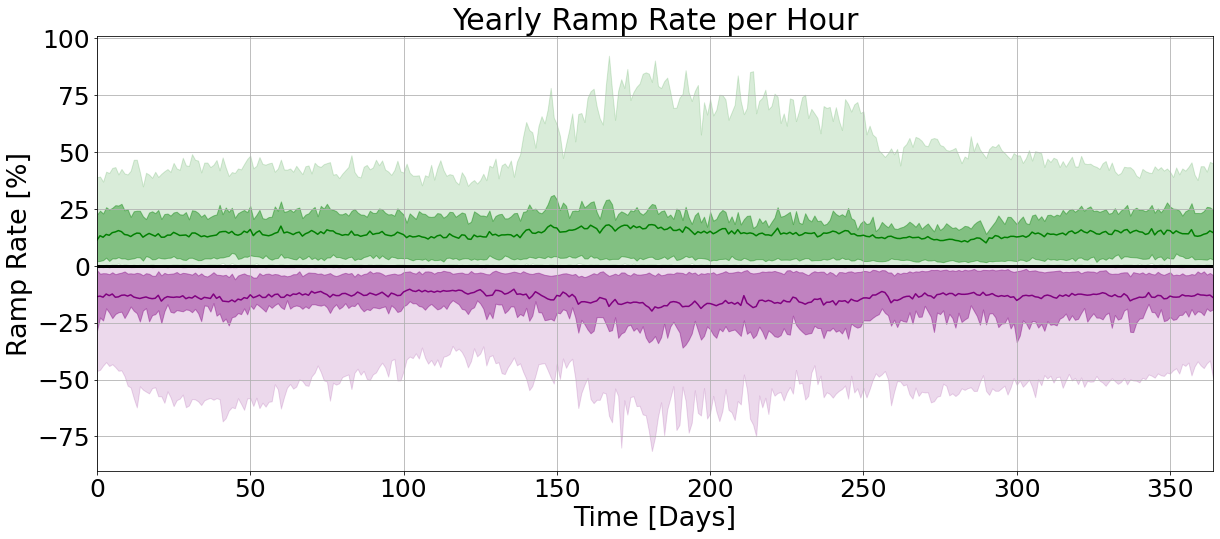

In [32]:
y_ =  np.arange(365, dtype = int)

plt.figure(figsize = (20, 8))

plt.plot(m_pos_, c = 'green', label = 'Daily Ramp-up Rates')
plt.fill_between(y_,q_100_pos_,q_0_pos_, alpha = 0.15,  edgecolor = 'green', facecolor = 'green', label = '$Q_{20}-Q_{80}$')
plt.fill_between(y_,q_75_pos_,q_25_pos_, alpha = 0.4,  edgecolor = 'green', facecolor = 'green', label = '$Q_{2.5}-Q_{97.5}$')

plt.plot(m_neg_, c = 'purple', label = 'Daily Ramp-down Rates')
plt.fill_between(y_,q_25_neg_,q_75_neg_, alpha = 0.4,  edgecolor = 'purple', facecolor = 'purple', label = '$Q_{20}-Q_{80}$')
plt.fill_between(y_,q_100_neg_,q_0_neg_, alpha = 0.15,  edgecolor = 'purple', facecolor = 'purple', label = '$Q_{2.5}-Q_{97.5}$')

plt.plot(np.repeat([0],365),'k',linewidth =3)

plt.title('Yearly Ramp Rate per Hour',fontsize=30)
#plt.suptitle('Solar Fraction = ' +  "{:.2f}".format(r_s) + ' | Wind Fraction= '+  "{:.2f}".format(r_w) + ' | Overbuild=' +  "{:.2f}".format(OB), ha = 'center', va = 'top',fontsize=17.)

plt.xlabel('Time [Days]', fontsize = 27)
plt.ylabel('Ramp Rate [%]', fontsize = 27 )
plt.xticks( fontsize=25)
plt.yticks( fontsize=25)
plt.xlim([0, 364])

#plt.legend(bbox_to_anchor=(1.05, 1.0), loc ='upper left' ,fontsize = 22.)
plt.savefig('/Users/dlopez/Desktop/india_power/Images/'+  '_Ramp_Rates'+'_'+"{:.2f}".format(r_s) + '_'+ "{:.2f}".format(r_w)+'_'+ "{:.1f}.png".format(OB), dpi = 'figure')


plt.grid()
plt.show()

# Yearly Analysis 

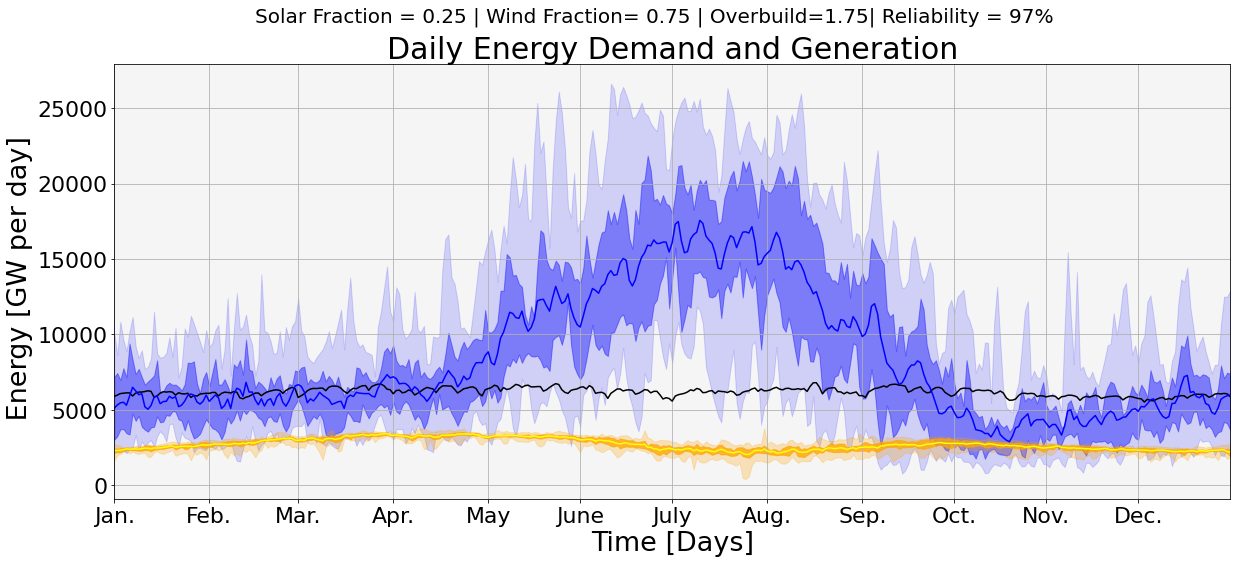

In [33]:
def year_stats(Data_):  
    # Median
    med_      = np.mean(Data_, axis = 1)
    # Quantile Statistics
    quantiles = stats.mstats.mquantiles(Data_, [0., 0.25, 0.75, 1.], axis = 1)
    q_0_      = quantiles[:,0]
    q_25_     = quantiles[:,1]
    q_75_     = quantiles[:,2]
    q_100_    = quantiles[:,3]
    return med_[:, np.newaxis], q_0_[:, np.newaxis], q_25_[:, np.newaxis], q_75_[:, np.newaxis], q_100_[:, np.newaxis]

# Yearly Wind gen Scale 
r_s = .25
r_w = 1. - r_s
OB  = 1.75

a_hat_s, a_hat_w, beta_s_, beta_w_ = _avg_system_scale(S_cf_, W_cf_, s_Cap_, w_Cap_, L, r_s, OB)

E_w_scaled_a_ =  a_hat_w * W_Cap_[:,:,np.newaxis] * W_cf_
E_w_hour_a_ = np.sum(E_w_scaled_a_, axis= 0)
E_w_reshape_a_ = E_w_hour_a_.reshape(365,24,14)
E_w_days_a_ = np.sum(E_w_reshape_a_,axis=1)

E_s_scaled_a_ =  a_hat_s * S_Cap_[:,:,np.newaxis] * S_cf_
E_s_hour_a_ = np.sum(E_s_scaled_a_, axis= 0)
E_s_reshape_a_ = E_s_hour_a_.reshape(365,24,14)
E_s_days_a_ = np.sum(E_s_reshape_a_,axis=1)

y_ =  np.arange(365, dtype = int)
year_ = np.array([0,31,60,91,122,152,182,213,244,274,304,334])
months_ = np.array(['Jan.','Feb.','Mar.','Apr.','May','June','July', 'Aug.','Sep.','Oct.','Nov.','Dec.'])
#3
S_med_a_, S_q_0_a_ , S_q_25_a_, S_q_75_a_, S_q_100_a_  = year_stats(E_s_days_a_)
W_med_a_, W_q_0_a_ , W_q_25_a_, W_q_75_a_, W_q_100_a_  = year_stats(E_w_days_a_)


plt.figure(figsize = (20, 8))
plt.grid()
plt.gca().set_facecolor('whitesmoke')

plt.title('Daily Energy Demand and Generation',fontsize = 30,loc = 'center')
plt.suptitle('Solar Fraction = ' +  "{:.2f}".format(r_s) + ' | Wind Fraction= '+  "{:.2f}".format(r_w) + ' | Overbuild=' +  "{:.2f}".format(OB)+ '| Reliability = 97%', ha = 'center', va = 'top',fontsize=20.)


plt.xlabel('Time [Days]', fontsize = 27)
plt.ylabel(' Energy [GW per day]', fontsize = 27 )

plt.plot(y_, L_days_/1000, 'k', label = 'Daily Load Demand')

plt.plot(y_,W_med_a_/1000, 'b', label = 'Daily Wind Generation')
plt.fill_between(y_, W_q_0_a_[:, 0]/1000., W_q_100_a_[:, 0]/1000., alpha = 0.15,  edgecolor = 'blue', facecolor = 'blue', label = '$Q_{2.5}-Q_{97.5}$')
plt.fill_between(y_, W_q_25_a_[:, 0]/1000., W_q_75_a_[:, 0]/1000., alpha = 0.4,  edgecolor = 'blue', facecolor = 'blue', label = '$Q_{20}-Q_{80}$')

plt.plot(y_, S_med_a_/1000, 'yellow', label = 'Daily Solar Generation')
plt.fill_between(y_, S_q_0_a_[:, 0]/1000., S_q_100_a_[:, 0]/1000., alpha = .25,  edgecolor = 'orange', facecolor = 'orange', label = '$Q_{2.5}-Q_{97.5}$')
plt.fill_between(y_, S_q_25_a_[:, 0]/1000., S_q_75_a_[:, 0]/1000., alpha = 0.75,  edgecolor = 'orange', facecolor = 'orange', label = '$Q_{20}-Q_{80}$')

plt.xticks(year_,months_,fontsize = 22.)
#plt.legend(bbox_to_anchor=(1.05, 1.0), loc='upper left' ,fontsize = 20.)
plt.yticks(fontsize=22.)
plt.xlim([0, 364])

plt.savefig('/Users/dlopez/Desktop/india_power/Images/'+ 'Yearly'+ "_{:.2f}".format(r_s) + '_'+ "{:.2f}".format(r_w)+'_'+  "{:.2f}.png".format(OB), dpi='figure',)
plt.show()

# Daily Energy Balance Funciton 

In [34]:
def _resiliance(S_cf_, W_cf_, S_Cap_, W_Cap_, l_, a_hat_s, a_hat_w):

    E_s_scaled_ = a_hat_s * S_Cap_[:, :, np.newaxis] * S_cf_
    E_s_hour_   = np.sum(E_s_scaled_, axis= 0)

    E_w_scaled_ = a_hat_w * W_Cap_[:, :, np.newaxis]  * W_cf_
    E_w_hour_   = np.sum(E_w_scaled_, axis= 0)
    
    E_net_ = (E_s_hour_ + E_w_hour_) - l_
    print(E_net_.shape)
    
    E_net_prime_ = np.reshape(E_net_, (365,24, 14))
    E_net_daily_ = np.sum(E_net_prime_, axis = 1)
    L_prime_     = np.reshape(l_, (365, 24, 1))
    L_net_daily_ = np.sum(L_prime_, axis=1)
    print(E_net_daily_.shape)
    print(L_net_daily_.shape)

    R_ = 100 * (E_net_daily_ / L_net_daily_)
    
    return R_

# Daily Energy Balance 

In [1]:
import matplotlib.colors as mcolors
r_s = .25
r_w = 1 - r_s
OB  = 1.75
print(r_s, r_w, OB)

a_hat_s, a_hat_w, beta_s_, beta_w_ = _avg_system_scale(S_cf_, W_cf_, s_Cap_, w_Cap_, L, r_s, OB)
print(a_hat_s, a_hat_w)

N_per_ =  _resiliance(S_cf_, W_cf_, S_Cap_, W_Cap_, l_, a_hat_s, a_hat_w)

plt.figure(figsize = (28, 8))
plt.title('Daily Energy Balance',fontsize = 30, loc = 'left')
#plt.suptitle(r'Solar Fraction= {}%'.format(int(r_s*100)) + ' | Wind Fraction= {}%'.format(int(r_w*100)) + ' | Overbuild= {:.2f}x'.format(OB), ha = 'center', va = 'top',fontsize=22.)

plt.xlabel('Time [Days]', fontsize = 27)
plt.ylabel('Years', fontsize = 27 )

norm = mcolors.TwoSlopeNorm(vmin = -100, vcenter = 0., vmax = 325)
cax = plt.imshow(N_per_.T, aspect = 'auto', interpolation = 'none', norm = norm, cmap = 'RdBu')

plt.xticks(year_,months_, fontsize=25)
plt.yticks(np.arange(0,14,1),np.arange(2004,2018,1), fontsize=25)
plt.xlim([0, 364])

cbar = plt.colorbar(cax, ticks = [-100., -50, 0, 100, 325.])
cbar.ax.set_yticklabels(['-100', '-50', '0', '167.5', '325'], fontsize = 22)  # vertically oriented colorbar

#cbar.set_ticklabels(cbar.get_ticks([300., 0., 100.]), size = 22)
cbar.set_label(label = 'Overgeneration [%]', fontsize = 25)

plt.savefig('/Users/dlopez/Desktop/india_power/Images/'+  'Best_Resiliance'+'_'+"{:.2f}".format(r_s) + '_'+ "{:.2f}".format(r_w)+'_'+ "{:.1f}.png".format(OB), dpi = 'figure')
plt.show()

0.25 0.75 1.75


NameError: name '_avg_system_scale' is not defined

0 1 1
0.0 0.578763923262407
(8760, 14)
(365, 14)
(365, 1)


/var/folders/99/fl4_sjvj2px9bv5z1fjz0w600000gn/T/ipykernel_21842/889059324.py:26: UserWarning: FixedFormatter should only be used together with FixedLocator
  cbar.set_ticklabels(cbar.get_ticks(), fontsize=22)


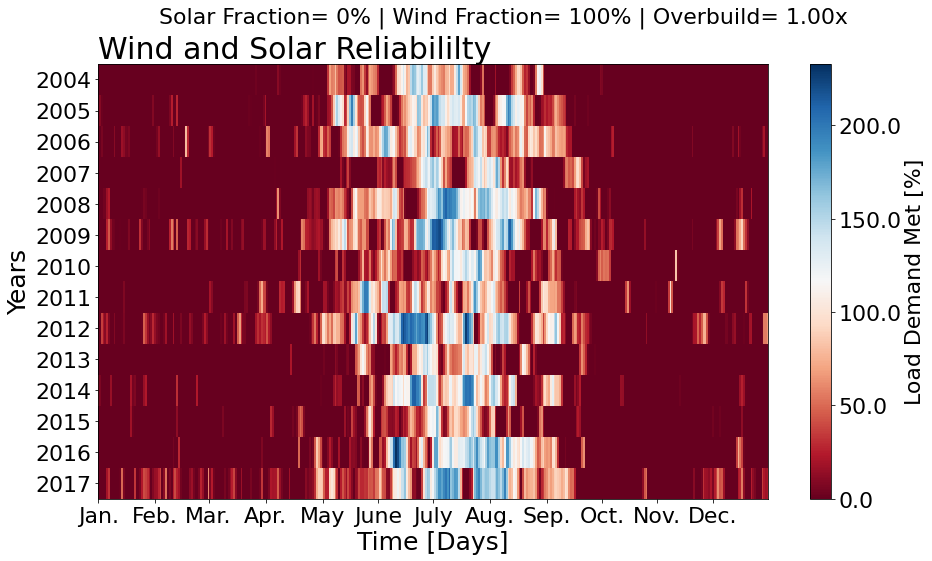

In [36]:
r_s = 0
r_w = 1 - r_s
OB  = 1
print(r_s, r_w, OB)

a_hat_s, a_hat_w, beta_s_, beta_w_ = _avg_system_scale(S_cf_, W_cf_, s_Cap_, w_Cap_, L, r_s, OB)
print(a_hat_s, a_hat_w)

N_per_ = _resiliance(S_cf_, W_cf_, S_Cap_, W_Cap_, l_, a_hat_s, a_hat_w)

plt.figure(figsize = (15, 8))
plt.title('Wind and Solar Reliabililty',fontsize = 30, loc = 'left')
plt.suptitle(r'Solar Fraction= {}%'.format(int(r_s*100)) + ' | Wind Fraction= {}%'.format(int(r_w*100)) + ' | Overbuild= {:.2f}x'.format(OB), ha = 'center', va = 'top',fontsize=22.)

plt.xlabel('Time [Days]', fontsize = 25)
plt.ylabel('Years', fontsize = 25 )

plt.imshow(N_per_.T, aspect = 'auto', interpolation = 'none', vmin = 0, cmap = 'RdBu')

plt.xticks(year_,months_, fontsize=22)
plt.yticks(np.arange(0,14,1),np.arange(2004,2018,1), fontsize=22)
plt.xlim([0, 364])


cbar = plt.colorbar()
cbar.set_ticklabels(cbar.get_ticks(), fontsize=22)
cbar.set_label(label ='Load Demand Met [%]', fontsize=22)
plt.savefig('/Users/dlopez/Desktop/india_power/Images/'+  'Worst_ Resiliance'+'_'+"{:.2f}".format(r_s) + '_'+ "{:.2f}".format(r_w)+'_'+ "{:.1f}.png".format(OB), dpi = 'figure')
plt.show()



In [ ]:
# This is using 0 battery storage 

plt.figure(figsize=(12,10))
plt.title( 'Loss of Load Expectation for RE ', fontsize = 30 )

plt.imshow(VRE_LOLE_[:,:11,], interpolation = 'none', vmax = 100, cmap = 'inferno')

plt.xticks(x_axis_, s_, fontsize = 17)
plt.xlabel('Solar Energy Generation [%]',fontsize=27)



plt.yticks(y_axis_, w_, fontsize = 17)
plt.ylabel('Wind Energy Generation [%]',fontsize=27)

cbar = plt.colorbar()
cbar.set_ticklabels(cbar.get_ticks(), fontsize=22)
cbar.set_label(label = '# of Unmet Days', fontsize=25)

plt.savefig( path_images + 'LOLE.png',dpi='figure',bbox_inches='tight')



plt.show()



# Scrap

In [104]:
r_s_ = np.array([0., 0.25, 0.5, 0.75, 1.])
OB_  = np.array([1.,1.25,1.5,1.75,2])
print(r_s_.size,OB_.size)
E_balance_ = np.zeros((14,4))
scalar = []
fraction = []
for i in range(OB_.size):
    for j in range(r_s_.size):
        a_hat_s, a_hat_w, beta_s_, beta_w_ = _avg_system_scale(S_cf_, W_cf_, s_Cap_, w_Cap_, L, r_s_[j],OB_[i])
        scalar.append((a_hat_s, a_hat_w))
        fraction.append((OB_[i],r_s_[j]))

5 5


In [105]:

scalar_= np.array(scalar)
print(scalar_[1][1])
per_tot_year_ = np.zeros((r_s_.size*OB_.size, 14, 4))

for i in range(r_s_.size*OB_.size):
    for j in range(0,14):
        per_tot_year_[i] = _hourly_reliability(S_cf_, W_cf_,L_prime_, S_Cap_, W_Cap_, scalar_[i][1], scalar_[i][0], j)


0.4340729424468053


5.0


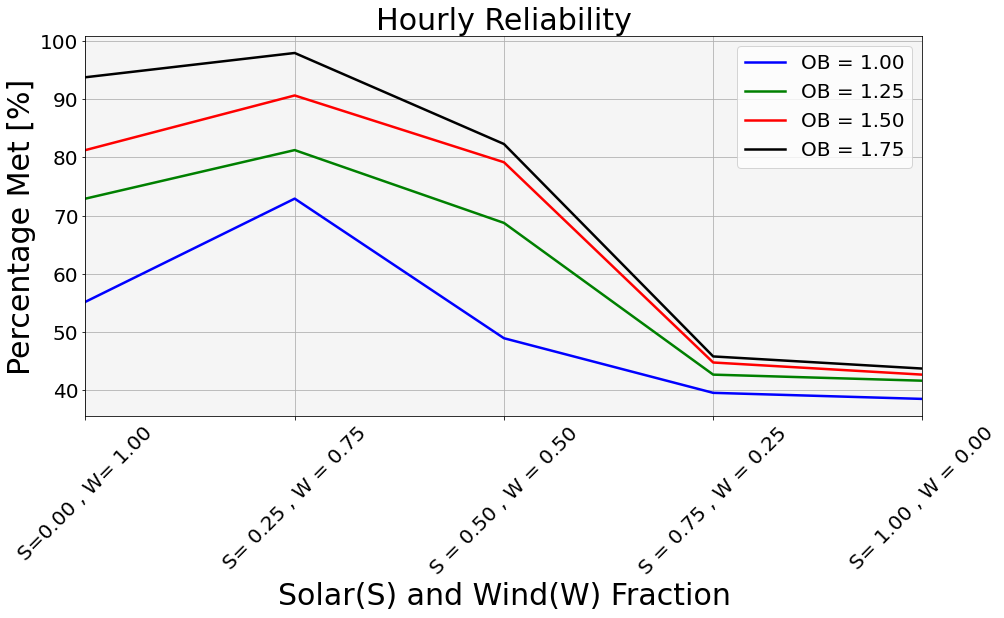

In [106]:
per_tot_= np.mean(np.mean(per_tot_year_,axis=2),axis=1)
i = (r_s_.size*OB_.size) / OB_.size
print(i)
per_tot_0_ = per_tot_[0:5]
per_tot_25_ = per_tot_[5:10]
per_tot_50_ = per_tot_[10:15]
per_tot_75_ = per_tot_[15:20]
per_tot_1_ = per_tot_[20:25]

plt.figure(figsize = (15, 7))
plt.gca().set_facecolor('whitesmoke')

plt.title('Hourly Reliability', fontsize=30) 
plt.plot(r_s_,per_tot_0_,  'b', linewidth=2.5, label = 'OB = ' +"{:.2f}".format(OB_[0]))
plt.plot(r_s_,per_tot_25_, 'g', linewidth=2.5, label = 'OB = ' +"{:.2f}".format(OB_[1]))
plt.plot(r_s_,per_tot_50_, 'r', linewidth=2.5, label = 'OB = ' +"{:.2f}".format(OB_[2]))
plt.plot(r_s_,per_tot_75_, 'k', linewidth=2.5, label = 'OB = ' +"{:.2f}".format(OB_[3]))
#plt.plot(r_s_,per_tot_1_, 'y',linewidth=2.5, label =  'OB = ' +"{:.2f}".format(OB_[4]))

plt.legend(loc ='upper right' ,fontsize = 20.)

plt.xticks(r_s_,['S=' + "{:.2f}".format(r_s_[0]) + ' , W= '+  "{:.2f}".format(1-r_s_[0]),
                 'S= ' + "{:.2f}".format(r_s_[1]) + ' , W = '+  "{:.2f}".format(1-r_s_[1]),
                 'S = ' + "{:.2f}".format(r_s_[2]) + ' , W = '+  "{:.2f}".format(1-r_s_[2]),
                 'S = ' + "{:.2f}".format(r_s_[3]) + ' , W = '+  "{:.2f}".format(1-r_s_[3]),
                 'S= ' + "{:.2f}".format(r_s_[4]) + ' , W = '+  "{:.2f}".format(1-r_s_[4])], rotation = 45, fontsize = 20)
plt.yticks(np.arange(.4,1.1,.1),np.arange(40,110,10,dtype=int),fontsize = 20)


plt.xlim(r_s_[0],r_s_[4])
plt.xlabel('Solar(S) and Wind(W) Fraction', fontsize=30) 
plt.ylabel('Percentage Met [%]',fontsize=30)
plt.grid()
plt.savefig('/Users/dlopez/Desktop/india_power/Images/' + 'Hourly Reliability.png')
plt.show()


[2259974025] [2.25997402e+08]


<Figure size 1800x360 with 0 Axes>

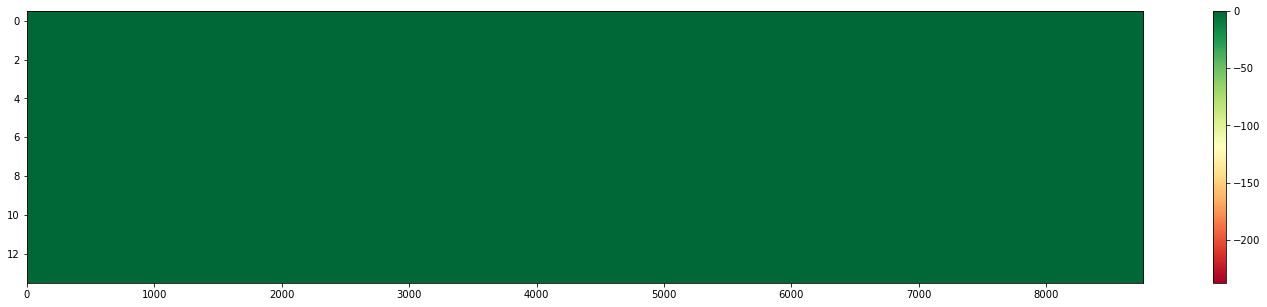

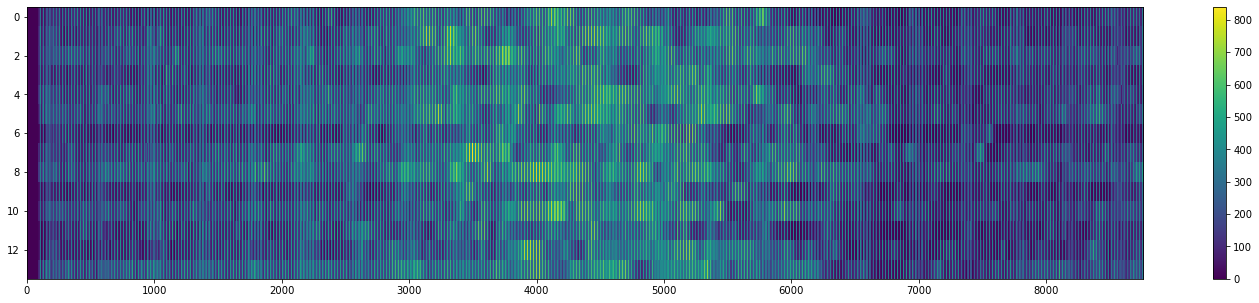

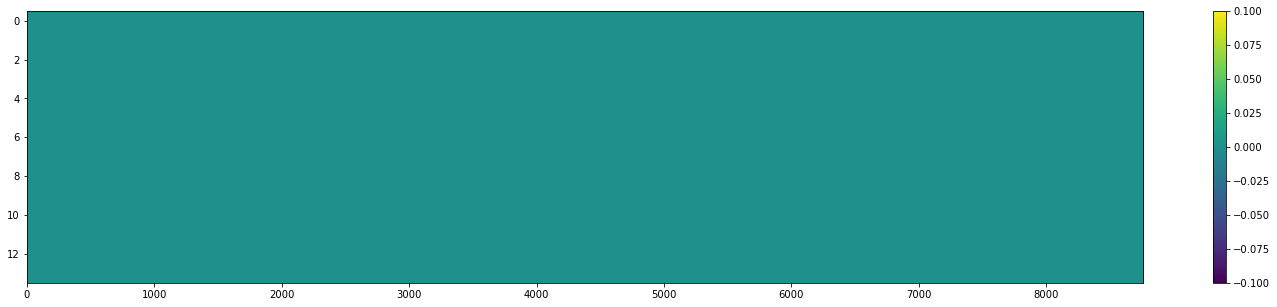

In [111]:
# Battery Storage 
print(L, b_Cap)
plt.figure(figsize = (25, 5))

plt.figure(figsize = (25, 5))
plt.imshow(L_net_.T/1000., aspect = 'auto', interpolation = 'none',  cmap = 'RdYlGn')
plt.colorbar()
plt.show()

plt.figure(figsize = (25, 5))
plt.imshow(L_bat_.T/1000., aspect = 'auto', interpolation = 'none')
plt.colorbar()
plt.show()

L_bat_[L_bat_ > 0.] = 0.

plt.figure(figsize = (25, 5))
plt.imshow(L_bat_.T/1000., aspect = 'auto', interpolation = 'none')
plt.colorbar()
plt.show()

0.0 1.0 1.0
0.0 0.578763923262407


/var/folders/99/fl4_sjvj2px9bv5z1fjz0w600000gn/T/ipykernel_5551/1169083511.py:31: UserWarning: FixedFormatter should only be used together with FixedLocator
  cbar.set_ticklabels(cbar.get_ticks(), fontsize=15)


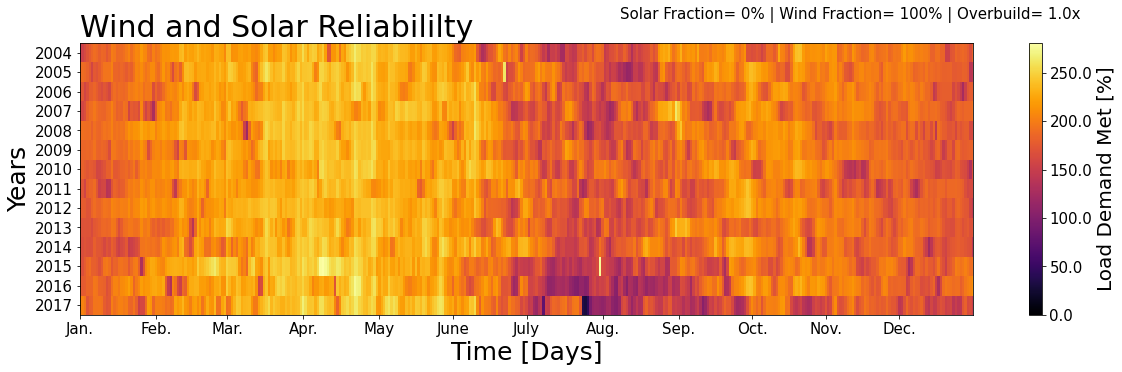

0.0 1.0 1.25
0.0 0.7234549040780087


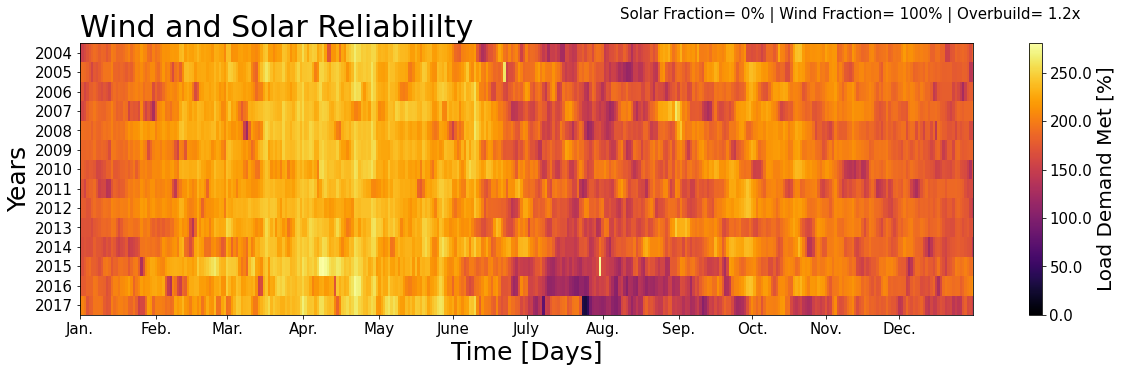

0.0 1.0 1.35
0.0 0.7813312964042495


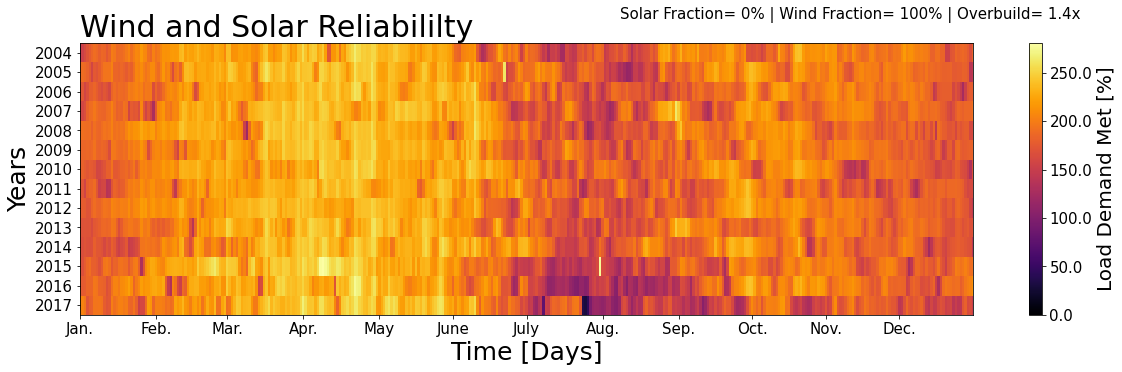

0.0 1.0 1.5
0.0 0.8681458848936106


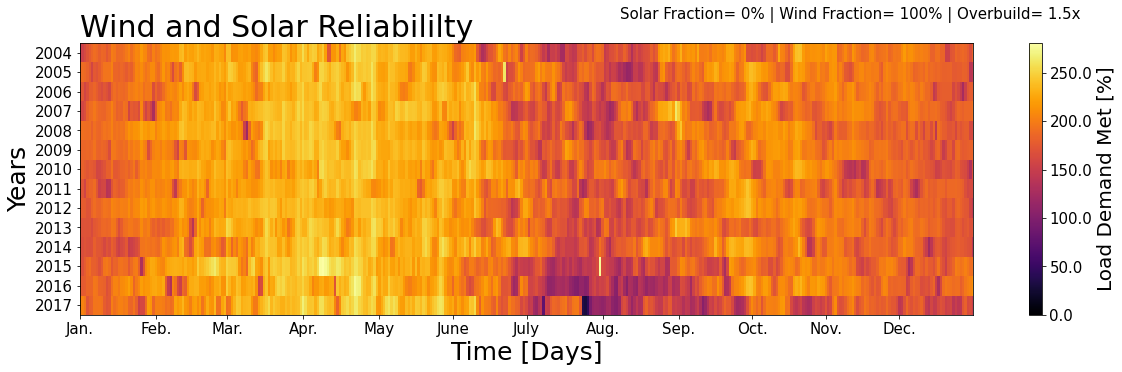

0.25 0.75 1.0
0.07147925920118788 0.4340729424468053


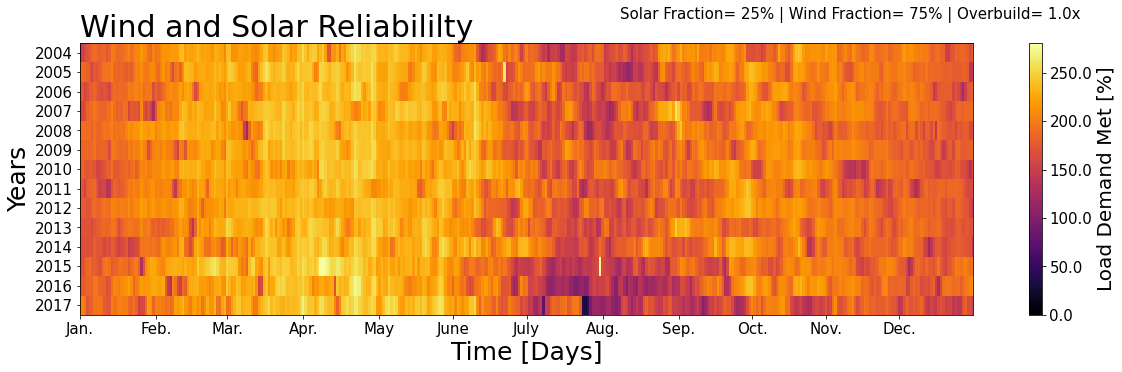

0.25 0.75 1.25
0.08934907400148484 0.5425911780585067


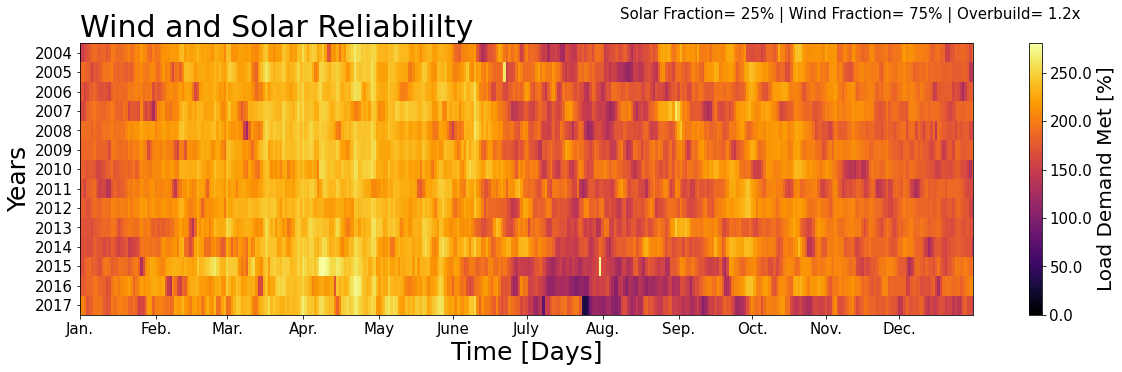

0.25 0.75 1.35
0.09649699992160364 0.5859984723031871


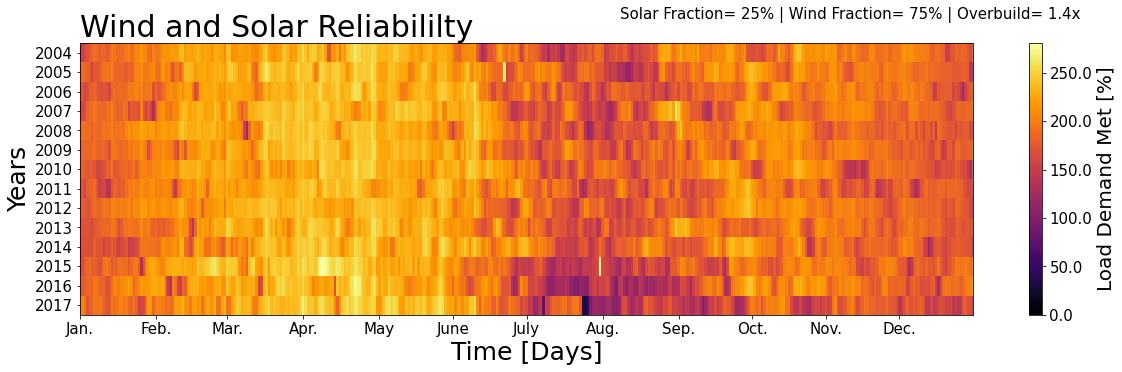

0.25 0.75 1.5
0.10721888880178182 0.6511094136702079


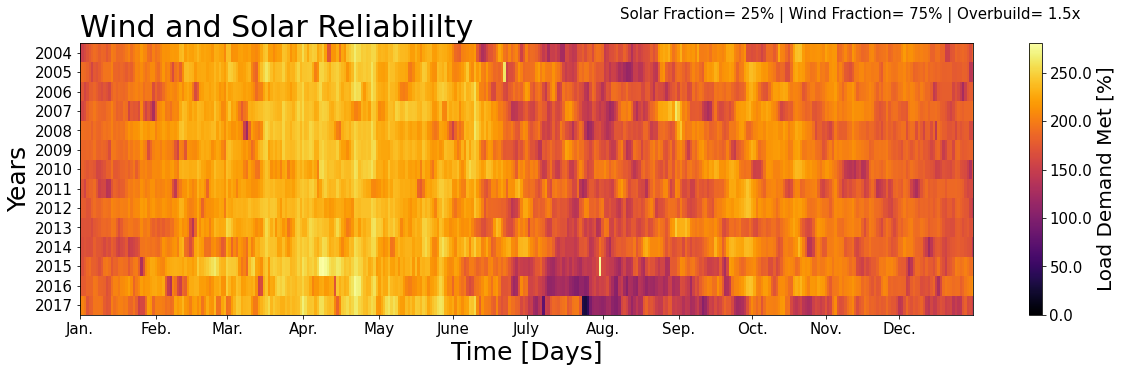

0.5 0.5 1.0
0.14295851840237575 0.2893819616312035


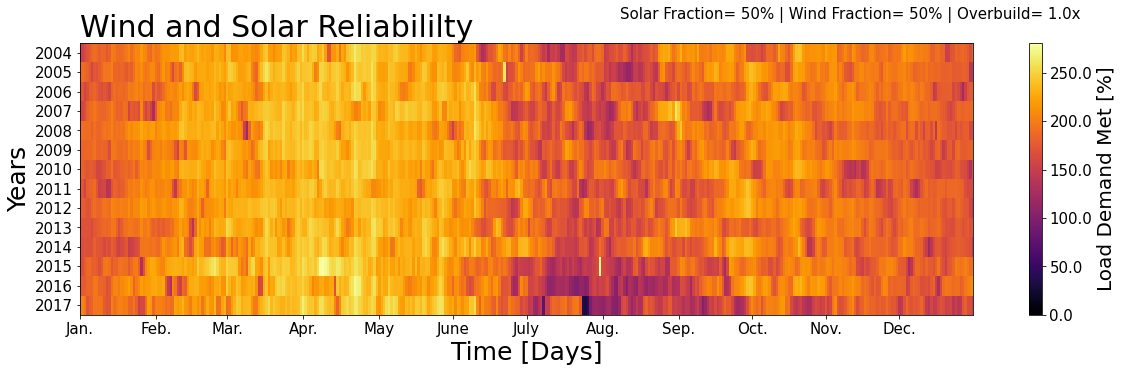

0.5 0.5 1.25
0.17869814800296968 0.36172745203900436


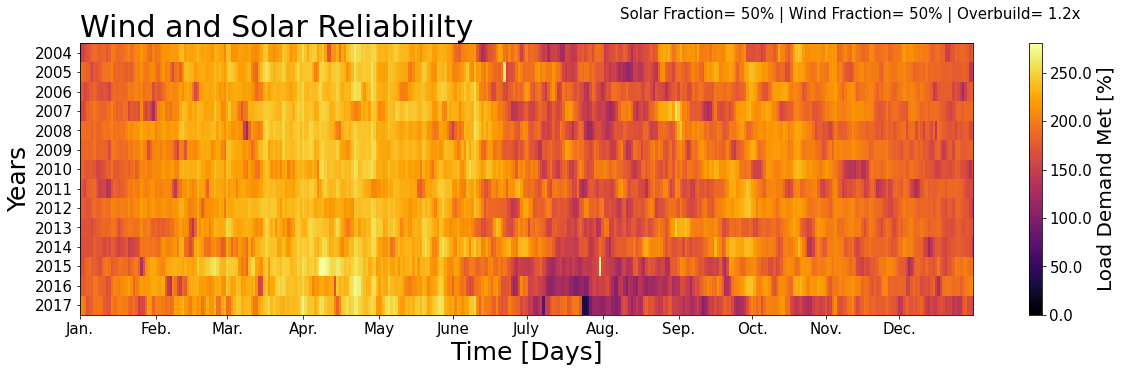

0.5 0.5 1.35
0.19299399984320728 0.39066564820212474


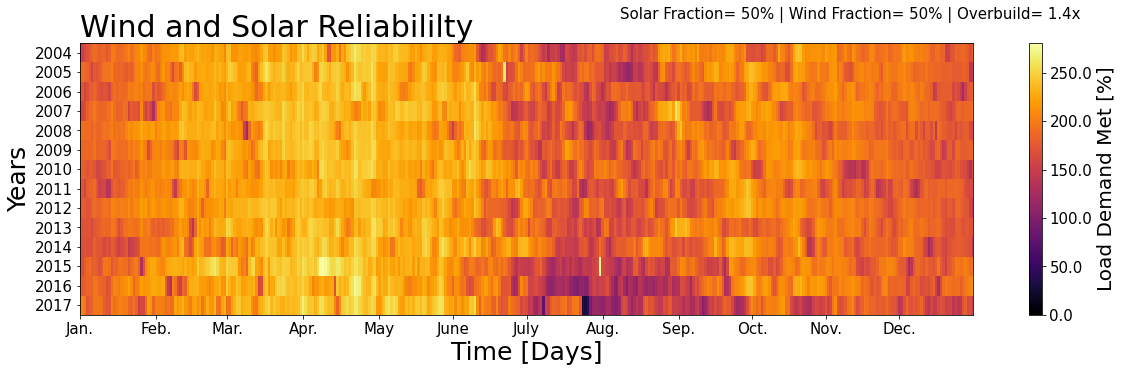

0.5 0.5 1.5
0.21443777760356364 0.4340729424468053


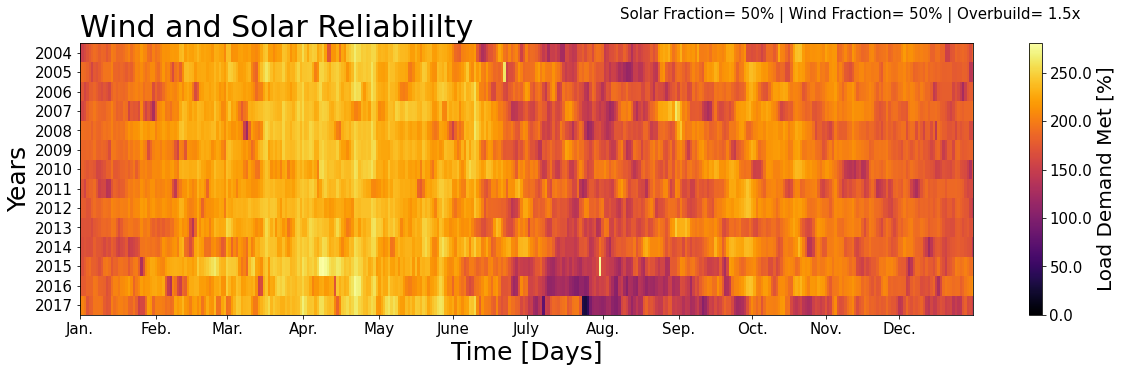

0.75 0.25 1.0
0.21443777760356364 0.14469098081560175


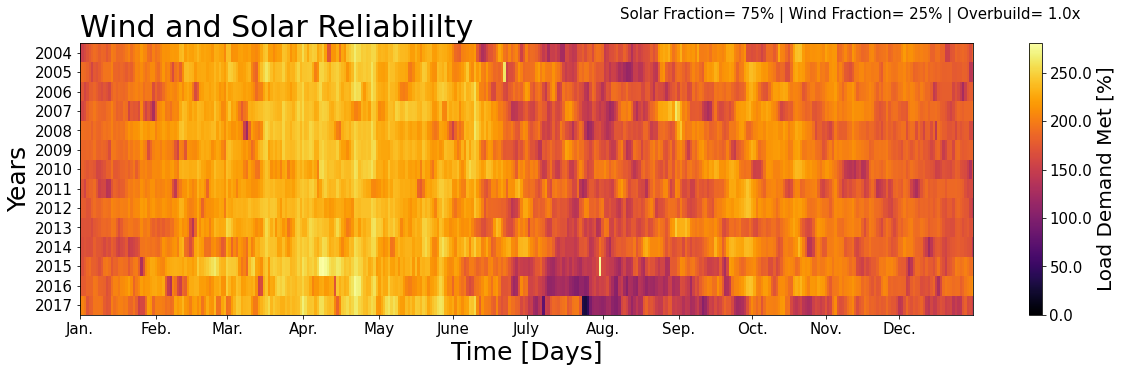

0.75 0.25 1.25
0.2680472220044545 0.18086372601950218


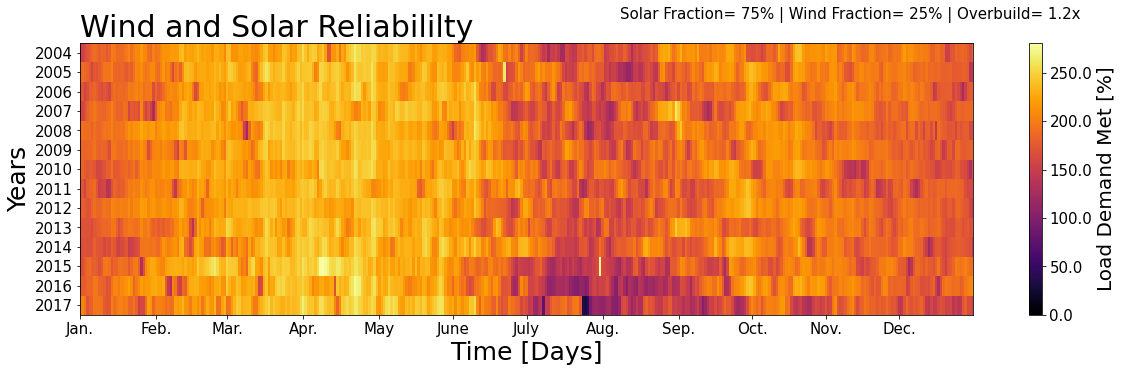

0.75 0.25 1.35
0.2894909997648109 0.19533282410106237


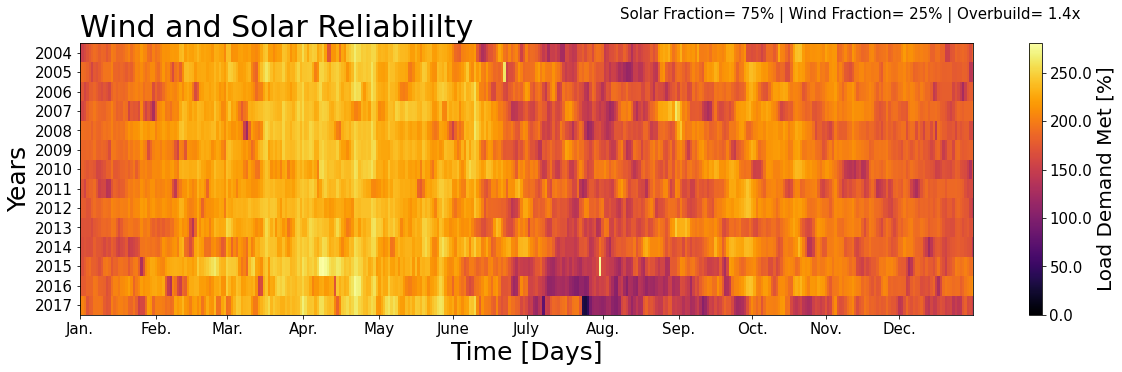

0.75 0.25 1.5
0.32165666640534546 0.21703647122340264


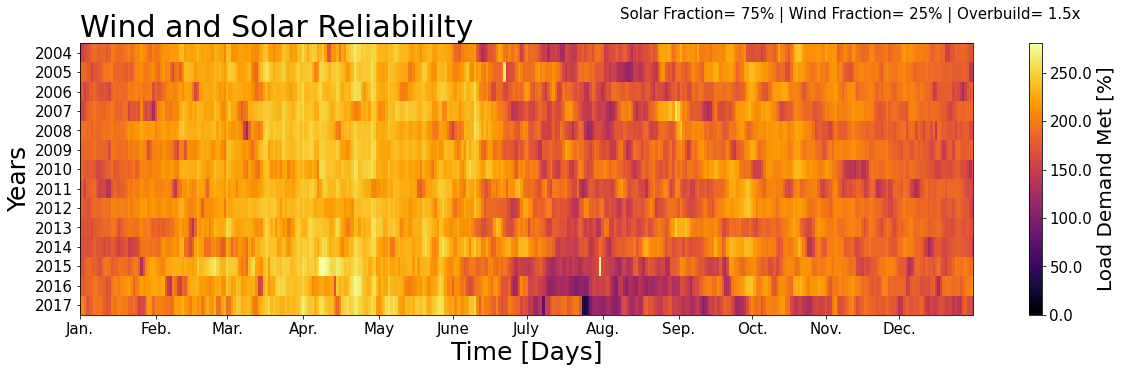

1.0 0.0 1.0
0.2859170368047515 0.0


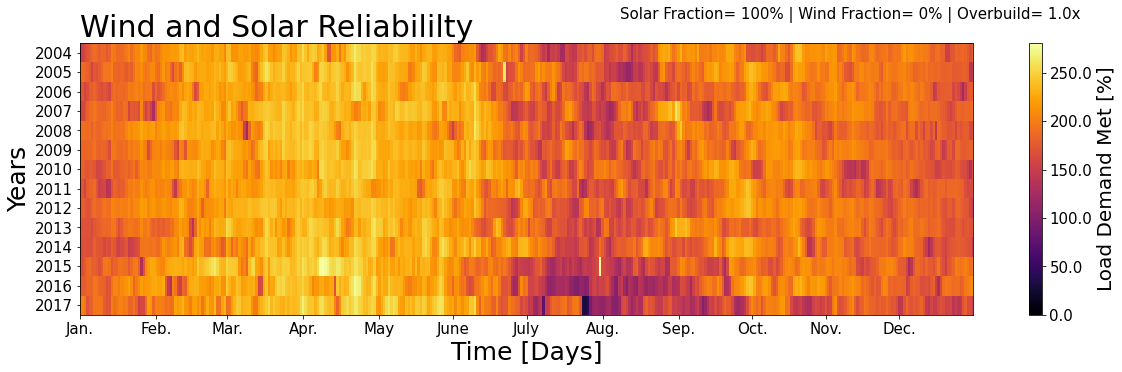

1.0 0.0 1.25
0.35739629600593936 0.0


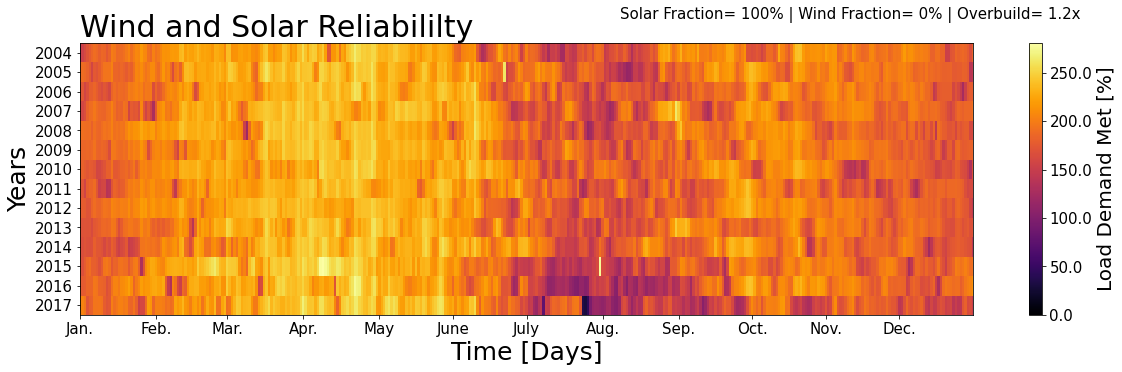

1.0 0.0 1.35
0.38598799968641456 0.0


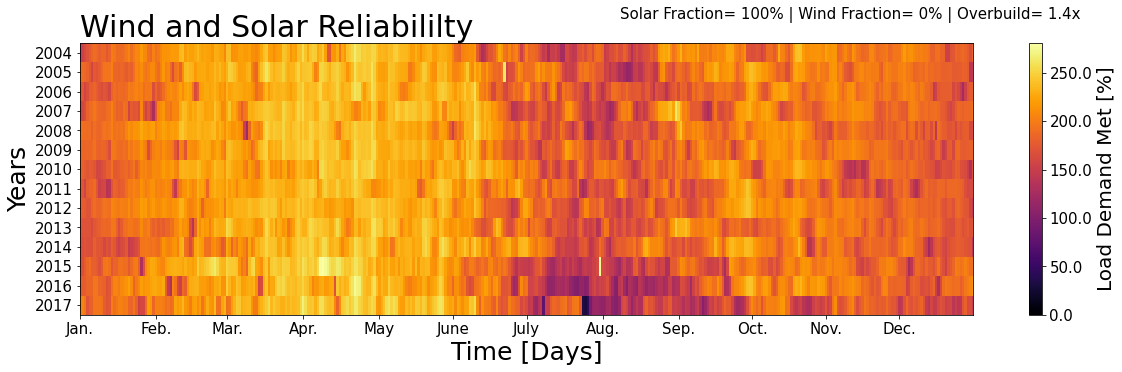

1.0 0.0 1.5
0.4288755552071273 0.0


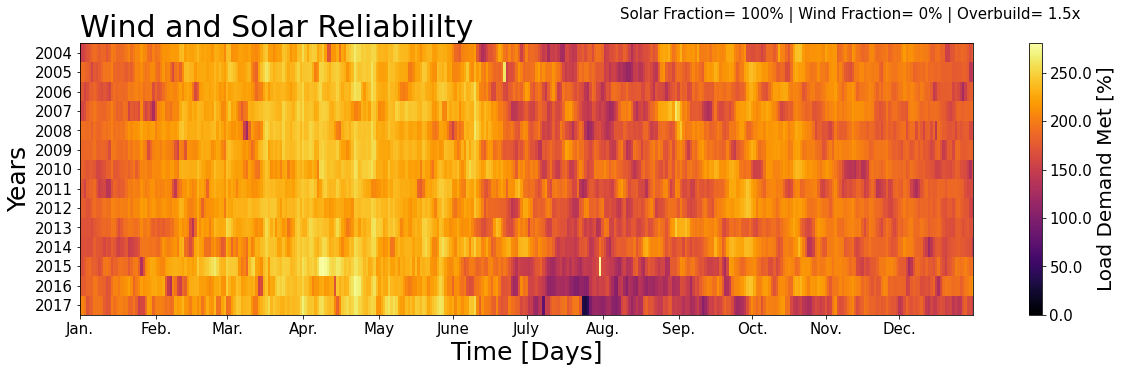

In [180]:
r_s_ = [0., 0.25, 0.5, 0.75, 1.]
OB_  = [1.,1.25, 1.35, 1.5]

for i in range(len(r_s_)):
    for j in range(len(OB_)):
        r_s = r_s_[i]
        r_w = 1 - r_s
        OB  = OB_[j]
        print(r_s, r_w, OB)
        
        a_hat_s, a_hat_w, beta_s_, beta_w_ = _avg_system_scale(S_cf_, W_cf_, s_Cap_, w_Cap_, L, r_s, OB)
        print(a_hat_s, a_hat_w)

        N_per_ =  _resiliance(E_s_hour_,E_w_hour_, l_, a_hat_s, a_hat_w)
      
        plt.figure(figsize = (20, 5))
        plt.title('Wind and Solar Reliabililty',fontsize = 30, loc = 'left')
        plt.suptitle(r'Solar Fraction= {}%'.format(int(r_s*100)) + ' | Wind Fraction= {}%'.format(int(r_w*100)) + ' | Overbuild= {:.1f}x'.format(OB), ha = 'left', va = 'top',fontsize=15.)

        plt.xlabel('Time [Days]', fontsize = 25)
        plt.ylabel('Years', fontsize = 25 )

        plt.imshow(N_per_.T, aspect = 'auto', interpolation = 'none', vmin = 0, cmap = 'inferno')

        plt.xticks(year_,months_, fontsize=15)
        plt.yticks(np.arange(0,14,1),np.arange(2004,2018,1), fontsize=15)
        plt.xlim([0, 364])

        
        cbar = plt.colorbar()
        cbar.set_ticklabels(cbar.get_ticks(), fontsize=15)
        cbar.set_label(label ='Load Demand Met [%]', fontsize=20)
        plt.savefig('/Users/dlopez/Desktop/india_power/Images/'+  'Resiliance'+'_'+"{:.2f}".format(r_s) + '_'+ "{:.2f}".format(r_w)+'_'+ "{:.1f}.png".format(OB), dpi = 'figure')
        plt.show()

 



        